In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import scipy.io as sio
import cmaps
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
# from importlib import reload
# reload(rw)
import roms_workspace as rw
import scipy as sci
import os
##========================================================================##
#  Stick to the guideline of beginning with the simplest approach,
#  only sea surface temperature (SST) was assimilated, and only
#  initial condition was adjusted.
#  Here we first validated the performance of ROMS I4D-VAR configured
#  in this strategy.
##========================================================================##
my_rootnl = '/Volumes/WD_3/'
my_rootda = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs'
nl_workspace_info = {
                     # 'run04/outputs':'FORWARD',
                     'outputs_SCORRECTION/outputs_201205':'Forward v4 scorrection',
                    # 'run17_v4/outputs':'FORWARD drggrd',
                     }
da_workspace_info = {
                     # 'workspace':'Adj ALL',
                     
                     'workspace_geopolarsst':'Assimilate geopolar sst',
                     # 'workspace_acsposst': 'Assimilate acspo sst',
                     # 'workspace03_nud_3d_b12hr':'Adj INI 12hr begin',
                     # 'workspace03_nud_2d':'NUD+Adj INI',
                     # 'workspace03_nud_3d':'NUD+Adj INI+3DAY',
            
                     }

var = 'temp'
areas = {
         'bh': ('Bohai Sea', [0,7]),
        'ys': ('Yellow Sea', [6.5,11]),
        'cre': ('Changjiang River Estuary',[10.5,14.5]),
        'ks': ('Kuroshio Current System', [21.5,24]),
        'all': ('East China Sea', [10,25])
}

nl_Vars = {}
nl_Workspaces = []
for i in range(len(nl_workspace_info)):
    nl_Workspaces.append(rw.Nl_workspace( MY_ROOT         =my_rootnl,
                                    workspace_name  =list(nl_workspace_info.keys())[i],
                                    workspace_detail=list(nl_workspace_info.values())[i]
                                   ))
    nl_Workspaces[i].load_mtfroms(isAna=False,Surf=True)


dab_Vars = {}
dab_Workspaces = []
for i in range(len(da_workspace_info)):
    dab_Workspaces.append(rw.Da_workspace(MY_ROOT         =my_rootda, 
                                    workspace_name  = list(da_workspace_info.keys())[i],
                                    workspace_detail= list(da_workspace_info.values())[i]
                                   ))
    dab_Workspaces[i].load_mtfroms(isAna=False, Surf=True)

daa_Vars = {}
daa_Workspaces = []
for i in range(len(da_workspace_info)):
    daa_Workspaces.append(rw.Da_workspace(MY_ROOT         =my_rootda, 
                                    workspace_name  = list(da_workspace_info.keys())[i],
                                    workspace_detail= list(da_workspace_info.values())[i]
                                   ))
    daa_Workspaces[i].load_mtfroms(isAna=True, Surf=True)

obs_ds = xr.open_dataset(os.path.join(my_rootda,
                                      'NOAA_GHRSST',
                                      'geopolar_sst_2012.nc'
                                      ))
# obs_time = obs_ds.obs_time.data.astype('float')/86400/1e9
obs_time = obs_ds.obs_time.data
obs_value = obs_ds.obs_value.data
obs_lon = obs_ds.obs_lon.data
obs_lat = obs_ds.obs_lat.data
obs_Vars = {} 
area_index={}
obs_inarea ={}
obslon_inarea ={}
obslat_inarea ={}
# area iteration 
for iw in range(len((nl_workspace_info))):
    for area in list(areas.keys()):
        print('loading %s in %s  area...'%(var,area))
        if iw == 0:
            nl_Vars[area] = []
        # loading data from FORWARD model outputs
        nl_Vars[area].append(nl_Workspaces[iw].pull_var2d(varname=         var, area=area,time_range=('2012-05-01','2012-07-21')))
for iw in range(len((da_workspace_info))):
    for area in list(areas.keys()):
        print('loading %s in %s  area...'%(var,area))
        if iw == 0:
            
            dab_Vars[area] = []
            daa_Vars[area] = []
        
        
        # loading data from prior outputs

        dab_Vars[area].append(dab_Workspaces[iw].pull_var2d(varname='%s_sur'%var, area=area,time_range=('2012-05-01','2012-06-30')))
        # loading data from posterior outputs
        daa_Vars[area].append(daa_Workspaces[iw].pull_var2d(varname='%s_sur'%var, area=area,time_range=('2012-05-01','2012-06-30')))

        #================================extrapolate observation data to model grid================================
        index_insea = np.where(~np.isnan(daa_Vars[area][0].value[0,:,:]))
        obs_Vars[area] = np.zeros(
                                [len(obs_ds.survey_time.data), 
                                 len(index_insea[0])]
                                ) 
        for itime, itime_obs in enumerate(obs_ds.survey_time.data[0:82]):
            index_thistime = np.where(obs_time == itime_obs)[0]
            obs_Vars[area][itime,:] = sci.interpolate.griddata(
                                                               np.c_[obs_lon[index_thistime],
                                                                    obs_lat[index_thistime]],
                                                               obs_value[index_thistime],
                                                               np.c_[daa_Vars[area][0].lon[index_insea],
                                                                     daa_Vars[area][0].lat[index_insea]],
                                                               method ='nearest')
        #==========================================================================================================
        # note that it's more resonable to interp model data to observation location 
        # since model grider is finer than observaion resolution
        #==========================================================================================================


Workspace: /Volumes/WD_3/outputs_SCORRECTION/outputs_201205
Workspace: /Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/workspace_geopolarsst
Workspace: /Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/workspace_geopolarsst


In [112]:
obslon_inarea ={}
obslat_inarea ={}

In [42]:
daa_Vars[area][0].val_obsgrd.shape

(732, 45510)

In [178]:
#================================calculate area-mean sst at observation location================================
# FORWARD model
dat_len = 82
obs_location = np.c_[
                     obs_lon[np.where(obs_time == obs_time[0])[0]],
                     obs_lat[np.where(obs_time == obs_time[0])[0]]
                    ]


for iw in range(len((nl_workspace_info))):
    for area in list(areas.keys()):
        nl_Vars[area][iw].val_obsgrd   = np.zeros([len( nl_Vars[area][iw].ocean_time), len(obs_location)])
        for i in range(1):
        
            nl_Vars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[nl_Vars[area][iw].lon.ravel(),
                                                                            nl_Vars[area][iw].lat.ravel()],
                                                                      nl_Vars[area][iw].value[i,:,:].ravel(),
                                                                      obs_location,
                                                                 )
for iw in range(len((da_workspace_info))):
    for area in list(areas.keys()):



        dab_Vars[area][iw].val_obsgrd  = np.zeros([len(dab_Vars[area][iw].ocean_time), len(obs_location)])

        daa_Vars[area][iw].val_obsgrd  = np.zeros([len(daa_Vars[area][iw].ocean_time), len(obs_location)])



        for i in  range(1):
            dab_Vars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[dab_Vars[area][iw].lon.ravel(),
                                                                            dab_Vars[area][iw].lat.ravel()],
                                                                      dab_Vars[area][iw].value[i,:,:].ravel(),
                                                                      obs_location,
                                                                      )

        for i in  range(1):
            daa_Vars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[daa_Vars[area][iw].lon.ravel(),
                                                                            daa_Vars[area][iw].lat.ravel()],
                                                                      daa_Vars[area][iw].value[i,:,:].ravel(),
                                                                      obs_location,
                                                                      )
for area in list(areas.keys()):
    area_index[area] = np.where(~np.isnan(daa_Vars[area][0].val_obsgrd[0,:]))
   
    obs_inarea[area] = np.zeros([dat_len,len(area_index[area][0])])*np.NAN
    obslon_inarea[area] = np.zeros([1,len(area_index[area][0])])*np.NAN
    obslat_inarea[area] = np.zeros([1,len(area_index[area][0])])*np.NAN
    # for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9):
    #     obs_thistime = obs_value[np.where(obs_time == itime)[0]]x
    #     obs_inarea[it, :] = obs_thistime[area_index[0]]
    # obs_inarea[area] =   obs_value[np.where(obs_time == obs_time[0])[0]][area_index[area][0]]
    obs_inarea[area] =   np.array([ obs_value[np.where(obs_time == itime)[0]][area_index[area][0]] for it,itime in enumerate(obs_ds.survey_time.data[0:dat_len])])
    obslon_inarea[area] =   obs_lon[np.where(obs_time == obs_time[0])[0]][area_index[area][0]]  
    obslat_inarea[area] =   obs_lat[np.where(obs_time == obs_time[0])[0]][area_index[area][0]]
    
for iw in range(len((nl_workspace_info))):
    for area in list(areas.keys()):
        nl_Vars[area][iw].val_obsgrd   = np.zeros([len( nl_Vars[area][iw].ocean_time), len(obslon_inarea[area])])
        for i, itime_nl in enumerate(nl_Vars[area][iw].ocean_time):
        
            nl_Vars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[nl_Vars[area][iw].lon.ravel(),
                                                                            nl_Vars[area][iw].lat.ravel()],
                                                                      nl_Vars[area][iw].value[i,:,:].ravel(),
                                                                      np.c_[obslon_inarea[area][:],
                                                                            obslat_inarea[area][:]],
                                                                     method ='nearest')
for iw in range(len((da_workspace_info))):
    for area in list(areas.keys()):



        dab_Vars[area][iw].val_obsgrd  = np.zeros([len(dab_Vars[area][iw].ocean_time), len(obslon_inarea[area])])

        daa_Vars[area][iw].val_obsgrd  = np.zeros([len(daa_Vars[area][iw].ocean_time), len(obslon_inarea[area])])



        for i, itime_daa in enumerate(dab_Vars[area][iw].ocean_time):
            dab_Vars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[dab_Vars[area][iw].lon.ravel(),
                                                                            dab_Vars[area][iw].lat.ravel()],
                                                                      dab_Vars[area][iw].value[i,:,:].ravel(),
                                                                      np.c_[obslon_inarea[area][:],
                                                                            obslat_inarea[area][:]],
                                                                      method ='nearest')

        for i, itime_daa in enumerate(daa_Vars[area][iw].ocean_time):
            daa_Vars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[daa_Vars[area][iw].lon.ravel(),
                                                                            daa_Vars[area][iw].lat.ravel()],
                                                                      daa_Vars[area][iw].value[i,:,:].ravel(),
                                                                      np.c_[obslon_inarea[area][:],
                                                                            obslat_inarea[area][:]],
                                                                      method ='nearest')


In [140]:
nl_Vars['ys'][0].val_obsgrd[11::24].

(31, 4589)

In [173]:
daa_Vars['ys'][0].ocean_time[24]

<xarray.DataArray 'ocean_time' ()>
array('2012-05-02T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    ocean_time  datetime64[ns] 2012-05-02T12:00:00
Attributes:
    standard_name:  time
    long_name:      time since initialization
    field:          time

In [104]:
daa_Vars['all'][0].val_obsgrd

array([[nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [144]:
obs_inarea['bh'].shape

(31, 2583)

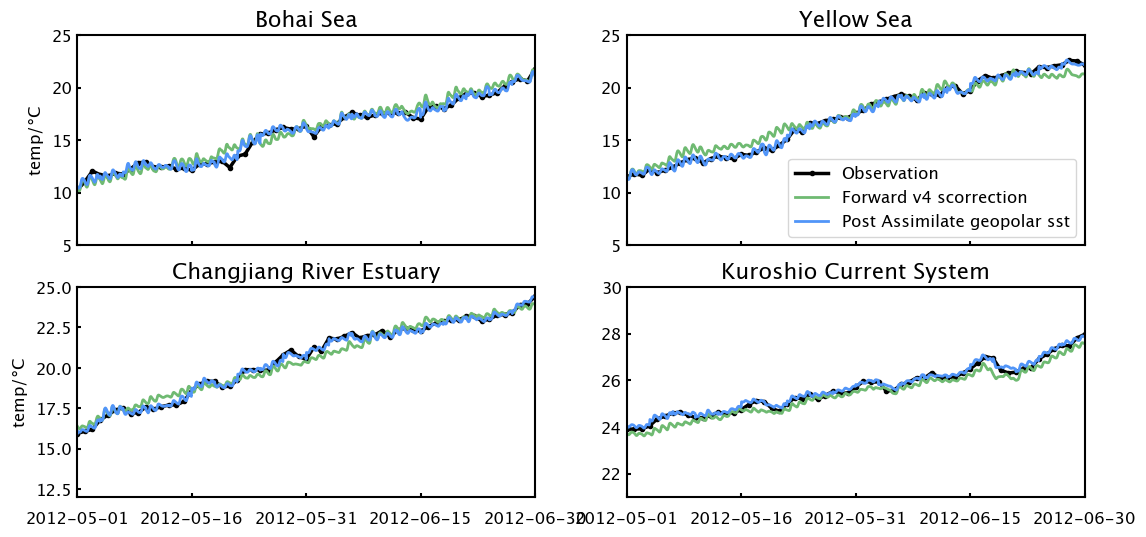

In [198]:
#==================================area-averaged time series validation 
#==================================in terms of OBS
areas = {
         'bh': ('Bohai Sea', [5,25]),
        'ys': ('Yellow Sea', [5,25]),
        'cre': ('Changjiang River Estuary',[12,25]),
        'ks': ('Kuroshio Current System', [21,30])
}

plt.rcParams['font.family'] = 'Lucida Grande'
# colorarray = cmaps.GMT_haxby.colors[:][:-8]
# nl_color= [colorarray[:][i] for i in np.ceil(np.linspace(0,len(colorarray)-1,4)).astype(int)]
# colorarray = cmaps.cmocean_algae.colors[:][50:]
# daa_color= [colorarray[:][i] for i in np.ceil(np.linspace(0,len(colorarray)-1,5)).astype(int)]
colorarray =   np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                ])/255
colorarray_blue = np.zeros([256,3])
for i in range(3):
    colorarray_blue[:,i] = np.interp(np.linspace(0,1,256), 
                                     np.linspace(0,1,len(colorarray)), 
                                     colorarray[:,i].T
                                    )
dab_color= [colorarray_blue[i,:] for i in np.ceil(np.linspace(0,len(colorarray_blue)-20,4)).astype(int)]

colorarray =   np.array(  [
                 [117,20,12],
                [140,26,17],
                [164,33,21],
                [188,39,26],
                [212,45,31],
                [233,52,37],
                [235,76,67],
                [233,52,37],
                [235,76,67],
                [237,117,113],
                [242,164,162]
                ])/255
colorarray_red = np.zeros([256,3])
for i in range(3):
    colorarray_red[:,i] = np.interp(np.linspace(0,1,256), 
                                     np.linspace(0,1,len(colorarray)), 
                                     colorarray[:,i].T
                                    )
daa_color= [colorarray_red[i,:] for i in np.ceil(np.linspace(0,len(colorarray_red)-20,4)).astype(int)]


colorarray_oran = cmaps.MPL_PRGn_r.colors[:63][:]
nl_color= [colorarray_oran[i][:] for i in np.ceil(np.linspace(0,len(colorarray_oran)-20,4)).astype(int)]

# colorarray_pi = cmaps.MPL_PRGn_r.colors[:63][:]
# dab_color= [colorarray_pi[i][:] for i in np.ceil(np.linspace(0,len(colorarray_pi)-1,4)).astype(int)]

iwnl = 0
iwda = 0
# obs_inarea = {}
fig = plt.figure(figsize=(13,6))
fig.tight_layout(pad=5.)
for i, (area, areainfo) in enumerate(areas.items()):
    ax = fig.add_subplot(2,2,i+1)
    
    for bnd in ax.spines.keys():
                            ax.spines[bnd].set_linewidth('1.5')
#     area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
   
#     obs_inarea[area] = np.zeros([30,len(area_index[0])])
    # for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9):
    #     obs_thistime = obs_value[np.where(obs_time == itime)[0]]
    #     obs_inarea[it, :] = obs_thistime[area_index[0]]
    # obs_inarea[area] =   [ obs_value[np.where(obs_time == itime)[0]][area_index[0]] for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9)]
    l1, =ax.plot(obs_ds.survey_time.data[0:dat_len],np.nanmean(obs_inarea[area],axis=1),linewidth = 2.5,color = 'k',marker= '.',label = 'Observation')
    l2, =ax.plot(nl_Vars[area][iwnl].ocean_time,np.nanmean(nl_Vars[area][iwnl].val_obsgrd,axis=1),
                 linewidth = 2,color = nl_color[2],label = nl_Workspaces[iwnl].workspace_detail)
    l3, =ax.plot(daa_Vars[area][iwda].ocean_time,np.nanmean(daa_Vars[area][iwda].val_obsgrd,axis=1),
                 linewidth = 2, color = dab_color[2], label = 'Post '+ daa_Workspaces[iwda].workspace_detail)
   
    # l4, =ax.plot(dab_Vars[area][iwda].ocean_time,np.nanmean(dab_Vars[area][iwda].val_obsgrd,axis=1),
                 # linewidth = 2, color = daa_color[2], label = 'Prior '+ dab_Workspaces[iwda].workspace_detail)
   
    ax.set_xticks(daa_Vars[area][iwda].ocean_time[0::24*15])
    ax.set_xlim([daa_Vars[area][iwda].ocean_time[0],
                 daa_Vars[area][iwda].ocean_time[-1]])
    # ax.tick_params('x',labelbottom=False)
    ax.tick_params(direction = 'in', length = 3, width = 1.5, labelsize = 12)
    # ax.set_ylim([0,8])
    
    if i+1 == 1 or i+1 == 2:
        ax.tick_params('x',labelbottom=False)
    
    ax.tick_params('x',pad=10)
    
    ax.set_title('%s' %areainfo[0],fontsize =16)
    ax.set_ylim(areainfo[1])
    if i +1 ==3 or i+1 ==1: ax.set_ylabel('temp/$\degree$C',fontsize = 12)
    
    # ax1={}
    # if i+ 1 == 1:
    #     ax1[i] = fig.add_axes([0.125,0.537,0.353,0.1])
    #     ax1[i].set_ylim([-3,3])
    #     ax1[i].set_yticks([-3,0,3])
    # elif i+1 ==2:
    #     ax1[i] = fig.add_axes([0.547,0.537,0.353,0.1])
    #     ax1[i].set_ylim([-1.5,1.5])
    #     ax1[i].set_yticks([-1.5,0,1.5])
    # elif i+1 ==3:
    #     ax1[i] = fig.add_axes([0.125,0.125,0.353,0.1])
    #     ax1[i].set_ylim([-1,1])
    #     ax1[i].set_yticks([-1,0,1])
    # elif i+1 ==4:
    #     ax1[i] = fig.add_axes([0.547,0.125,0.353,0.1])
    #     ax1[i].set_ylim([-1,1])
#         ax1[i].set_yticks([-1,0,1])
    
#     for bnd in ax1[i].spines.keys():
#             ax1[i].spines[bnd].set_visible(False)
#     # ax1[i].plot(daa_Vars[area].ocean_time,np.nanmean(daa_Vars[area].val_obsgrd[:,area_index[area][0]],axis=(1))*0,alpha=0)
#     l5, =ax1[i].plot(obs_ds.survey_time.data,np.nanmean(onobstime_dnl[area][iwnl],axis=1),linewidth =2,color= nl_color[3],marker= '.',label = 'Bias Forward')
#     l6, =ax1[i].plot(obs_ds.survey_time.data,np.nanmean(onobstime_ddaa[area][iwda],axis=1),linewidth =2,color= dab_color[3],marker= '.',label = 'Bias geopolar sst')
   
#     l7, =ax1[i].plot(obs_ds.survey_time.data,np.nanmean(onobstime_ddaa[area][iwda+1],axis=1),linewidth =2,color= daa_color[3],marker= '.',label = 'Bias acspo sst')
   

#     ax1[i].tick_params('x',labelbottom=False)
#     ax1[i].tick_params('y',labelleft=False,labelright=True)
#     ax1[i].tick_params(direction='in',bottom =0, left = 0,right = 1,length = 3, width = 1.5)
#     ax1[i].set_xticks(daa_Vars[area][iwda].ocean_time[0::24*3])
#     ax1[i].set_xlim([daa_Vars[area][iwda].ocean_time[0],
#                  daa_Vars[area][iwda].ocean_time[-1]])
#     ax1[i].set_facecolor('none')
    if i+1 == 2: ax.legend(handles=[l1,l2,l3],fontsize=12)
    # if i +1 ==2 or i+1 ==4: ax1[i].set_ylabel(6temp/$\degree$C')
# plt.savefig('roms_i4dvar_valid_obsgrd_adj_ini.pdf',bbox_inches='tight')
# plt.savefig('roms_i4dvar_valid_obsgrd_adj_ini.jpeg',dpi=1200,bbox_inches='tight')
# plt.savefig('dasst_sst_contrast.pdf',bbox_inches='tight')

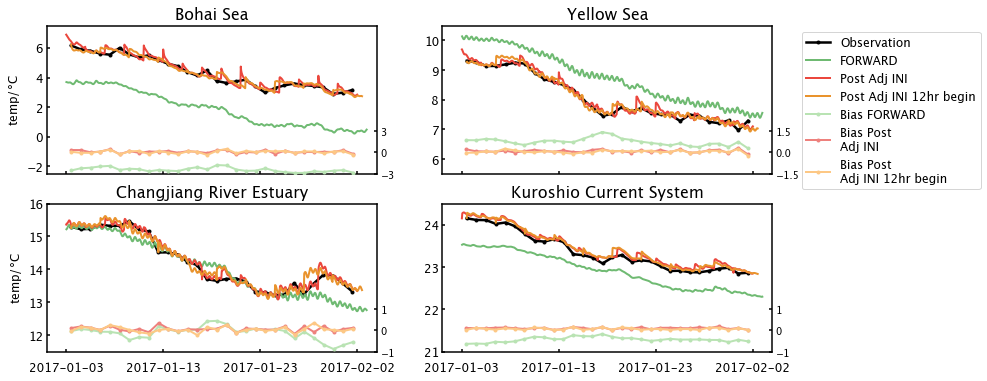

In [42]:
#==================================area-averaged posterior time series contrast
#==================================between different configuration
areas = {
         'bh': ('Bohai Sea', [-2.5,7.5]),
        'ys': ('Yellow Sea', [5.5,10.5]),
        'cre': ('Changjiang River Estuary',[11.5,16]),
        'ks': ('Kuroshio Current System', [21,24.5])
}
#====================================Calculate on observation grid
plt.rcParams['font.family'] = 'Lucida Grande'
# colorarray = cmaps.GMT_haxby.colors[:][:-8]
# nl_color= [colorarray[:][i] for i in np.ceil(np.linspace(0,len(colorarray)-1,4)).astype(int)]
# colorarray = cmaps.cmocean_algae.colors[:][50:]
# daa_color= [colorarray[:][i] for i in np.ceil(np.linspace(0,len(colorarray)-1,5)).astype(int)]
colorarray =   np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                ])/255
colorarray_blue = np.zeros([256,3])
for i in range(3):
    colorarray_blue[:,i] = np.interp(np.linspace(0,1,256), 
                                     np.linspace(0,1,len(colorarray)), 
                                     colorarray[:,i].T
                                    )
nl_color= [colorarray_blue[i,:] for i in np.ceil(np.linspace(0,len(colorarray_blue)-20,4)).astype(int)]

colorarray =   np.array(  [
                 [117,20,12],
                [140,26,17],
                [164,33,21],
                [188,39,26],
                [212,45,31],
                [233,52,37],
                [235,76,67],
                [233,52,37],
                [235,76,67],
                [237,117,113],
                [242,164,162]
                ])/255
colorarray_red = np.zeros([256,3])
for i in range(3):
    colorarray_red[:,i] = np.interp(np.linspace(0,1,256), 
                                     np.linspace(0,1,len(colorarray)), 
                                     colorarray[:,i].T
                                    )
daa_color= [colorarray_red[i,:] for i in np.ceil(np.linspace(0,len(colorarray_red)-20,4)).astype(int)]



colorarray_oran = cmaps.MPL_PuOr.colors[:63][:]
daa2_color= [colorarray_oran[i][:] for i in np.ceil(np.linspace(0,len(colorarray_oran)-20,4)).astype(int)]
colorarray_green = cmaps.MPL_PRGn_r.colors[:63][:]
nl_color= [colorarray_green[i][:] for i in np.ceil(np.linspace(0,len(colorarray_green)-20,4)).astype(int)]
# colorarray_pi = cmaps.MPL_PRGn_r.colors[:63][:]
# dab_color= [colorarray_pi[i][:] for i in np.ceil(np.linspace(0,len(colorarray_pi)-1,4)).astype(int)]
iwnl = 0
iwda=0
iwda1=1
# obs_inarea = {}
fig = plt.figure(figsize=(13,6))
fig.tight_layout(pad=5.)
for i, (area, areainfo) in enumerate(areas.items()):
    ax = fig.add_subplot(2,2,i+1)
    
    for bnd in ax.spines.keys():
                            ax.spines[bnd].set_linewidth('1.5')
#     area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
   
#     obs_inarea[area] = np.zeros([30,len(area_index[0])])
    # for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9):
    #     obs_thistime = obs_value[np.where(obs_time == itime)[0]]
    #     obs_inarea[it, :] = obs_thistime[area_index[0]]
    # obs_inarea[area] =   [ obs_value[np.where(obs_time == itime)[0]][area_index[0]] for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9)]
    l1, =ax.plot(obs_ds.survey_time.data.astype('float')/86400/1e9,np.nanmean(obs_inarea[area],axis=1),linewidth = 2.5,color = 'k',marker= '.',label = 'Observation')
    l2, =ax.plot(nl_Vars[area][iwnl].ocean_time,np.nanmean(nl_Vars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1)),
                 linewidth = 2,color = nl_color[2],label = nl_Workspaces[iwnl].workspace_detail)
    l3, =ax.plot(dab_Vars[area][iwda].ocean_time,np.nanmean(daa_Vars[area][iwda].val_obsgrd[:,area_index[area][0]],axis=(1)),
                 linewidth = 2, color = daa_color[2], label = 'Post '+ daa_Workspaces[iwda].workspace_detail)
   
    l4, =ax.plot(daa_Vars[area][iwda1].ocean_time,np.nanmean(daa_Vars[area][iwda1].val_obsgrd[:,area_index[area][0]],axis=(1)),
                 linewidth = 2, color = daa2_color[2], label = 'Post '+ daa_Workspaces[iwda1].workspace_detail)
   
    ax.set_xticks(daa_Vars[area][iw].ocean_time[0::240].astype('float')/86400/1e9)
    ax.set_xlim([daa_Vars[area][iw].ocean_time[0].astype('float')/86400/1e9-2,
                 daa_Vars[area][iw].ocean_time[-1].astype('float')/86400/1e9+2])
    # ax.tick_params('x',labelbottom=False)
    ax.tick_params(direction = 'in', length = 3, width = 1.5, labelsize = 12)
    # ax.set_ylim([0,8])
    
    if i+1 == 1 or i+1 == 2:
        ax.tick_params('x',labelbottom=False)
    
    ax.tick_params('x',pad=10)
    
    ax.set_title('%s' %areainfo[0],fontsize =16)
    ax.set_ylim(areainfo[1])
    if i +1 ==3 or i+1 ==1: ax.set_ylabel('temp/$\degree$C',fontsize = 12)
    
    ax1={}
    if i+ 1 == 1:
        ax1[i] = fig.add_axes([0.125,0.537,0.353,0.1])
        ax1[i].set_ylim([-3,3])
        ax1[i].set_yticks([-3,0,3])
    elif i+1 ==2:
        ax1[i] = fig.add_axes([0.547,0.537,0.353,0.1])
        ax1[i].set_ylim([-1.5,1.5])
        ax1[i].set_yticks([-1.5,0,1.5])
    elif i+1 ==3:
        ax1[i] = fig.add_axes([0.125,0.125,0.353,0.1])
        ax1[i].set_ylim([-1,1])
        ax1[i].set_yticks([-1,0,1])
    elif i+1 ==4:
        ax1[i] = fig.add_axes([0.547,0.125,0.353,0.1])
        ax1[i].set_ylim([-1,1])
        ax1[i].set_yticks([-1,0,1])
    
    for bnd in ax1[i].spines.keys():
            ax1[i].spines[bnd].set_visible(False)
    # ax1[i].plot(daa_Vars[area].ocean_time,np.nanmean(daa_Vars[area].val_obsgrd[:,area_index[area][0]],axis=(1))*0,alpha=0)
    l5, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,np.nanmean(onobstime_dnl[area][iwnl],axis=1),linewidth =2,color= nl_color[3],marker= '.',label = 'Bias FORWARD')
    
    l6, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,np.nanmean(onobstime_ddaa[area][iwda],axis=1),linewidth =2,color= daa_color[3],marker= '.',label = 'Bias Post \n'+daa_Workspaces[iwda].workspace_detail)
    l7, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,np.nanmean(onobstime_ddaa[area][iwda1],axis=1),linewidth =2,color= daa2_color[3],marker= '.',label = 'Bias Post \n'+daa_Workspaces[iwda1].workspace_detail)
   

    ax1[i].tick_params('x',labelbottom=False)
    ax1[i].tick_params('y',labelleft=False,labelright=True)
    ax1[i].tick_params(direction='in',bottom =0, left = 0,right = 1,length = 3, width = 1.5)
    ax1[i].set_xticks(daa_Vars[area][iw].ocean_time[0::240].astype('float')/86400/1e9)
    ax1[i].set_xlim([daa_Vars[area][iw].ocean_time[0].astype('float')/86400/1e9-2,
                 daa_Vars[area][iw].ocean_time[-1].astype('float')/86400/1e9+2])
    ax1[i].set_facecolor('none')
    if i+1 ==1 : ax.legend(bbox_to_anchor=(2.85, 1.0),handles=[l1,l2,l3,l4,l5,l6,l7],fontsize=12)
    # if i +1 ==2 or i+1 ==4: ax1[i].set_ylabel('temp/$\degree$C')
# plt.savefig('roms_i4dvar_valid_obsgrd_adj_ini.vs.all_post.pdf',bbox_inches='tight')
plt.savefig('./fig_contrast/adj_ini.vs.adj_ini_nud_b12hr/post/sst/roms_i4dvar_valid_obsgrd_adj_ini.vs.nud+ini_b12hr.jpeg',dpi=1200,bbox_inches='tight')
# plt.savefig('roms_i4dvar_valid_obsgrd_adj_ini.vs.nud+ini.jpeg',dpi=1200,bbox_inches='tight')

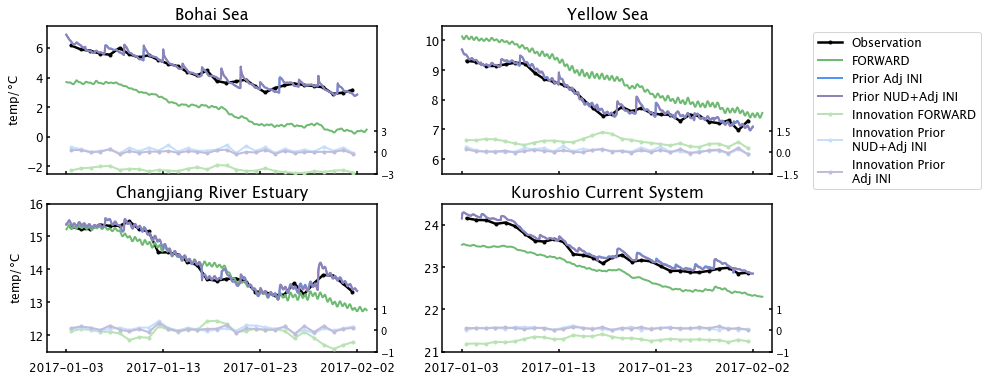

In [ ]:
#==================================area-averaged prior time series contrast
#==================================between different configuration
areas = {
         'bh': ('Bohai Sea', [-2.5,7.5]),
        'ys': ('Yellow Sea', [5.5,10.5]),
        'cre': ('Changjiang River Estuary',[11.5,16]),
        'ks': ('Kuroshio Current System', [21,24.5])
}
#====================================Calculate on observation grid
plt.rcParams['font.family'] = 'Lucida Grande'
# colorarray = cmaps.GMT_haxby.colors[:][:-8]
# nl_color= [colorarray[:][i] for i in np.ceil(np.linspace(0,len(colorarray)-1,4)).astype(int)]
# colorarray = cmaps.cmocean_algae.colors[:][50:]
# daa_color= [colorarray[:][i] for i in np.ceil(np.linspace(0,len(colorarray)-1,5)).astype(int)]
colorarray =   np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                ])/255
colorarray_blue = np.zeros([256,3])
for i in range(3):
    colorarray_blue[:,i] = np.interp(np.linspace(0,1,256), 
                                     np.linspace(0,1,len(colorarray)), 
                                     colorarray[:,i].T
                                    )
dab_color= [colorarray_blue[i,:] for i in np.ceil(np.linspace(0,len(colorarray_blue)-20,4)).astype(int)]



colorarray_oran = cmaps.MPL_PuOr_r.colors[:63][:]
dab2_color= [colorarray_oran[i][:] for i in np.ceil(np.linspace(0,len(colorarray_oran)-20,4)).astype(int)]

colorarray_green = cmaps.MPL_PRGn_r.colors[:63][:]
nl_color= [colorarray_green[i][:] for i in np.ceil(np.linspace(0,len(colorarray_green)-20,4)).astype(int)]
# colorarray_pi = cmaps.MPL_PRGn_r.colors[:63][:]
# dab_color= [colorarray_pi[i][:] for i in np.ceil(np.linspace(0,len(colorarray_pi)-1,4)).astype(int)]

iw=1
# obs_inarea = {}
fig = plt.figure(figsize=(13,6))
fig.tight_layout(pad=5.)
for i, (area, areainfo) in enumerate(areas.items()):
    ax = fig.add_subplot(2,2,i+1)
    
    for bnd in ax.spines.keys():
                            ax.spines[bnd].set_linewidth('1.5')
#     area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
   
#     obs_inarea[area] = np.zeros([30,len(area_index[0])])
    # for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9):
    #     obs_thistime = obs_value[np.where(obs_time == itime)[0]]
    #     obs_inarea[it, :] = obs_thistime[area_index[0]]
    # obs_inarea[area] =   [ obs_value[np.where(obs_time == itime)[0]][area_index[0]] for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9)]
    l1, =ax.plot(obs_ds.survey_time.data.astype('float')/86400/1e9,np.nanmean(obs_inarea[area],axis=1),linewidth = 2.5,color = 'k',marker= '.',label = 'Observation')
    l2, =ax.plot(nl_Vars[area][0].ocean_time,np.nanmean(nl_Vars[area][0].val_obsgrd[:,area_index[area][0]],axis=(1)),
                 linewidth = 2,color = nl_color[2],label = nl_Workspaces[0].workspace_detail)
    
   
    l3, =ax.plot(daa_Vars[area][0].ocean_time,np.nanmean(daa_Vars[area][0].val_obsgrd[:,area_index[area][0]],axis=(1)),
                 linewidth = 2, color = dab_color[2], label = 'Prior '+ daa_Workspaces[0].workspace_detail)
    l4, =ax.plot(daa_Vars[area][1].ocean_time,np.nanmean(daa_Vars[area][1].val_obsgrd[:,area_index[area][0]],axis=(1)),
                 linewidth = 2, color = dab2_color[2], label = 'Prior '+ daa_Workspaces[1].workspace_detail)
   
    ax.set_xticks(daa_Vars[area][iw].ocean_time[0::240].astype('float')/86400/1e9)
    ax.set_xlim([daa_Vars[area][iw].ocean_time[0].astype('float')/86400/1e9-2,
                 daa_Vars[area][iw].ocean_time[-1].astype('float')/86400/1e9+2])
    # ax.tick_params('x',labelbottom=False)
    ax.tick_params(direction = 'in', length = 3, width = 1.5, labelsize = 12)
    # ax.set_ylim([0,8])
    
    if i+1 == 1 or i+1 == 2:
        ax.tick_params('x',labelbottom=False)
    
    ax.tick_params('x',pad=10)
    
    ax.set_title('%s' %areainfo[0],fontsize =16)
    ax.set_ylim(areainfo[1])
    if i +1 ==3 or i+1 ==1: ax.set_ylabel('temp/$\degree$C',fontsize = 12)
    
    ax1={}
    if i+ 1 == 1:
        ax1[i] = fig.add_axes([0.125,0.537,0.353,0.1])
        ax1[i].set_ylim([-3,3])
        ax1[i].set_yticks([-3,0,3])
    elif i+1 ==2:
        ax1[i] = fig.add_axes([0.547,0.537,0.353,0.1])
        ax1[i].set_ylim([-1.5,1.5])
        ax1[i].set_yticks([-1.5,0,1.5])
    elif i+1 ==3:
        ax1[i] = fig.add_axes([0.125,0.125,0.353,0.1])
        ax1[i].set_ylim([-1,1])
        ax1[i].set_yticks([-1,0,1])
    elif i+1 ==4:
        ax1[i] = fig.add_axes([0.547,0.125,0.353,0.1])
        ax1[i].set_ylim([-1,1])
        ax1[i].set_yticks([-1,0,1])
    
    for bnd in ax1[i].spines.keys():
            ax1[i].spines[bnd].set_visible(False)
    # ax1[i].plot(daa_Vars[area].ocean_time,np.nanmean(daa_Vars[area].val_obsgrd[:,area_index[area][0]],axis=(1))*0,alpha=0)
    l5, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,np.nanmean(onobstime_dnl[area][0],axis=1),linewidth =2,color= nl_color[3],marker= '.',label = 'Innovation FORWARD')
    l6, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,np.nanmean(onobstime_ddaa[area][1],axis=1),linewidth =2,color= dab_color[3],marker= '.',label = 'Innovation Prior \n'+daa_Workspaces[1].workspace_detail)
   
    l7, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,np.nanmean(onobstime_ddaa[area][0],axis=1),linewidth =2,color= dab2_color[3],marker= '.',label = 'Innovation Prior \n'+daa_Workspaces[0].workspace_detail)
   

    ax1[i].tick_params('x',labelbottom=False)
    ax1[i].tick_params('y',labelleft=False,labelright=True)
    ax1[i].tick_params(direction='in',bottom =0, left = 0,right = 1,length = 3, width = 1.5)
    ax1[i].set_xticks(daa_Vars[area][iw].ocean_time[0::240].astype('float')/86400/1e9)
    ax1[i].set_xlim([daa_Vars[area][iw].ocean_time[0].astype('float')/86400/1e9-2,
                 daa_Vars[area][iw].ocean_time[-1].astype('float')/86400/1e9+2])
    ax1[i].set_facecolor('none')
    if i+1 ==1 : ax.legend(bbox_to_anchor=(2.85, 1.0),handles=[l1,l2,l3,l4,l5,l6,l7],fontsize=12)
    # if i +1 ==2 or i+1 ==4: ax1[i].set_ylabel('temp/$\degree$C')
# plt.savefig('roms_i4dvar_valid_obsgrd_adj_ini.vs.all_prior.pdf',bbox_inches='tight')
# plt.savefig('roms_i4dvar_valid_obsgrd_adj_ini.vs.all.jpeg',dpi=1200,bbox_inches='tight')

In [ ]:
obs_ds.survey_time.data

In [187]:
#==================================time-variant area-specific 
#==================================posterior and prior spatial distribution 
#==================================validation 
lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)
figsize = (11,9)
markersize = 10
iwnl = 0
iwda = 0
plt.rcParams['font.family'] = 'Lucida Grande'
# area = 'ks'
# for area in ['bh','ys','cre','ks','all']:
for area in ['all']:
    if area == 'bh':
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 0
        vmax_sst = 8
        markersize = 15
    elif area == 'ys':
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vmin_sst = 6
        vmax_sst = 12
        markersize = 20
    elif area == 'cre':
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 11
        vmax_sst = 18
    elif area == 'ks':
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        lon_interval = 4
        lat_interval = 3
        vmin_sst = 22
        vmax_sst = 26
    elif area =='all':
        figsize = (11,12)
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];
        lon_interval = 5
        lat_interval = 5
        vmin_sst = 5
        vmax_sst = 30
    # for it in range(len(obs_ds.survey_time.data)):
    for it in range(dat_len):
        fig = plt.figure(figsize=figsize, constrained_layout = True)
        #===============================observation spatial pattern
        ax = fig.add_subplot(3,3,1,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
        ax.scatter(obslon_inarea[area], obslat_inarea[area],
                   markersize,
                   obs_inarea[area][it,:],
                   cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   marker='s',
                   transform = ccrs.PlateCarree(),zorder=-2)
        ax.set_title('Observation',fontsize=16)
        fig.text(0.12,0.32,str(obs_ds.survey_time.data[it]),fontsize = 12)
        #===============================posterior spatial pattern
        ax = fig.add_subplot(3,3,2,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)

        c2=ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
                   markersize,
                   daa_Vars[area][iwda].val_obsgrd[it*24,:],

                   cmap = my_sst, vmin = vmin_sst,vmax=vmax_sst,
                   marker='s',
                   transform = ccrs.PlateCarree(),zorder=-2)
        ax.set_title('Posterior geoplor sst',fontsize=16)

                #==== colobar
        # position=fig.add_axes([ 0.1875,0.12, 0.325, 0.045,])


        # cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(6,14,2))
        # for bnd in position.spines.keys():
        #         position.spines[bnd].set_linewidth('1.5')
        # position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

        # cb.set_label('$\degree$C',fontsize = 12) 
        #===============================innovation spatial pattern
        ax = fig.add_subplot(3,3,3,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        c3 = ax.scatter(obslon_inarea[area], obslat_inarea[area],
                   markersize,
                   # daa_Vars[area][iw].val_obsgrd[11+it,area_index[area]]-obs_inarea[area][it][:],
                   daa_Vars[area][iwda].val_obsgrd[it*24,:]- 
                   obs_inarea[area][it,:],
                   marker='s',
                   vmin = -2, vmax = 2, cmap=my_div,
                   transform = ccrs.PlateCarree(),zorder=-2)
        ax.set_title('Difference',fontsize=16)
            #---- colrbar
        # position=fig.add_axes([ 0.7575,0.12, 0.165, 0.045,])


        # cb2 = fig.colorbar(c3, cax = position, orientation='horizontal',ticks = np.arange(-2,3,1))
        # for bnd in position.spines.keys():
        #         position.spines[bnd].set_linewidth('1.5')
        # position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
        # cb2.set_label('$\degree$C',fontsize = 12) 
        # fig.colorbar(c3)
        # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

        # fig = plt.figure(figsize=figsize, constrained_layout = True)

        #===============================observation spatial pattern
        ax = fig.add_subplot(3,3,4,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
        ax.scatter(obslon_inarea[area],obslat_inarea[area],
                   markersize,
                   obs_inarea[area][it,:],
                   cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   marker='s',
                   transform = ccrs.PlateCarree(),zorder = -2)
        # ax.set_title('Observation',fontsize=16)
        
        #===============================posterior spatial pattern
        ax = fig.add_subplot(3,3,5,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)

        c2=ax.scatter(obslon_inarea[area],obslat_inarea[area],
                   markersize,
                   dab_Vars[area][iwda].val_obsgrd[it*24,:],

                   cmap = my_sst, vmin = vmin_sst,vmax=vmax_sst,
                   marker='s',
                   transform = ccrs.PlateCarree(),zorder = -2)
        ax.set_title('Prior geopolar sst',fontsize=16)

                #==== colobar
        # position=fig.add_axes([ 0.1875,0.12, 0.325, 0.045,])


        # cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(6,14,2))
        # for bnd in position.spines.keys():
        #         position.spines[bnd].set_linewidth('1.5')
        # position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

        # cb.set_label('$\degree$C',fontsize = 12) 
        #===============================innovation spatial pattern
        ax = fig.add_subplot(3,3,6,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        c3 = ax.scatter(obslon_inarea[area],obslat_inarea[area],
                   markersize,
                   dab_Vars[area][iwda].val_obsgrd[it*24,:]
                   -obs_inarea[area][it,:],
                   marker='s',
                   vmin = -2, vmax = 2, cmap=my_div,
                   transform = ccrs.PlateCarree(),zorder = -2)
        ax.set_title('Difference',fontsize=16)
            #---- colrbar
        # position=fig.add_axes([ 0.7575,0.12, 0.165, 0.045,])


        # cb2 = fig.colorbar(c3, cax = position, orientation='horizontal',ticks = np.arange(-2,3,1))
        # for bnd in position.spines.keys():
        #         position.spines[bnd].set_linewidth('1.5')
        # position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
        # cb2.set_label('$\degree$C',fontsize = 12) 
        # fig.colorbar(c3)
        # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

        # fig = plt.figure(figsize=figsize, constrained_layout = True)

        #===============================observation spatial pattern
        ax = fig.add_subplot(3,3,7,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)

        # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
        ax.scatter(obslon_inarea[area],obslat_inarea[area],
                   markersize,
                   obs_inarea[area][it,:],
                   cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   marker='s',
                   transform = ccrs.PlateCarree())
        # ax.set_title('Observation',fontsize=16)
        #===============================posterior spatial pattern
        ax = fig.add_subplot(3,3,8,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('y',labelleft=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        c2=ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
                   markersize,
                   0.5*(
                       nl_Vars[area][iwnl].val_obsgrd[it*24+11,:]+
                       nl_Vars[area][iwnl].val_obsgrd[it*24+12,:]
                   ),

                   cmap = my_sst, vmin = vmin_sst,vmax=vmax_sst,
                   marker='s',
                   transform = ccrs.PlateCarree(),zorder = -2)
        ax.set_title('FORWARD',fontsize=16)
                #==== colobar
        position=fig.add_axes([ 0.1875,-0.05, 0.325, 0.025,])


        cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+2,2))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

        cb.set_label('$\degree$C',fontsize = 12) 
        #===============================innovation spatial pattern
        ax = fig.add_subplot(3,3,9,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('y',labelleft=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        c3 = ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
                   markersize,
                   0.5*(
                       nl_Vars[area][iwnl].val_obsgrd[it*24+11,:]+
                       nl_Vars[area][iwnl].val_obsgrd[it*24+12,:]
                   )-
                   obs_inarea[area][it,:],
                   marker='s',
                   vmin = -2, vmax = 2, cmap=my_div,
                   transform = ccrs.PlateCarree(),zorder = -2)
        ax.set_title('Difference',fontsize=16)
            #---- colrbar
        position=fig.add_axes([ 0.7575,-0.05, 0.165, 0.025,])


        cb2 = fig.colorbar(c3, cax = position, orientation='horizontal',ticks = np.arange(-2,3,1))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
        cb2.set_label('$\degree$C',fontsize = 12) 
        # plt.show()
        # fig.colorbar(c3)
        plt.savefig('./%s/fig_valid/%s/%s.jpeg'%(list(da_workspace_info.keys())[0],area,str(it+1)),dpi=100,bbox_inches='tight')
        plt.close()

In [168]:
list(da_workspace_info.keys())[0]

'workspace_geopolarsst'

/Users/onecountrylee/opt/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/onecountrylee/opt/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/onecountrylee/opt/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Users/onecountrylee/opt/anaconda3/li

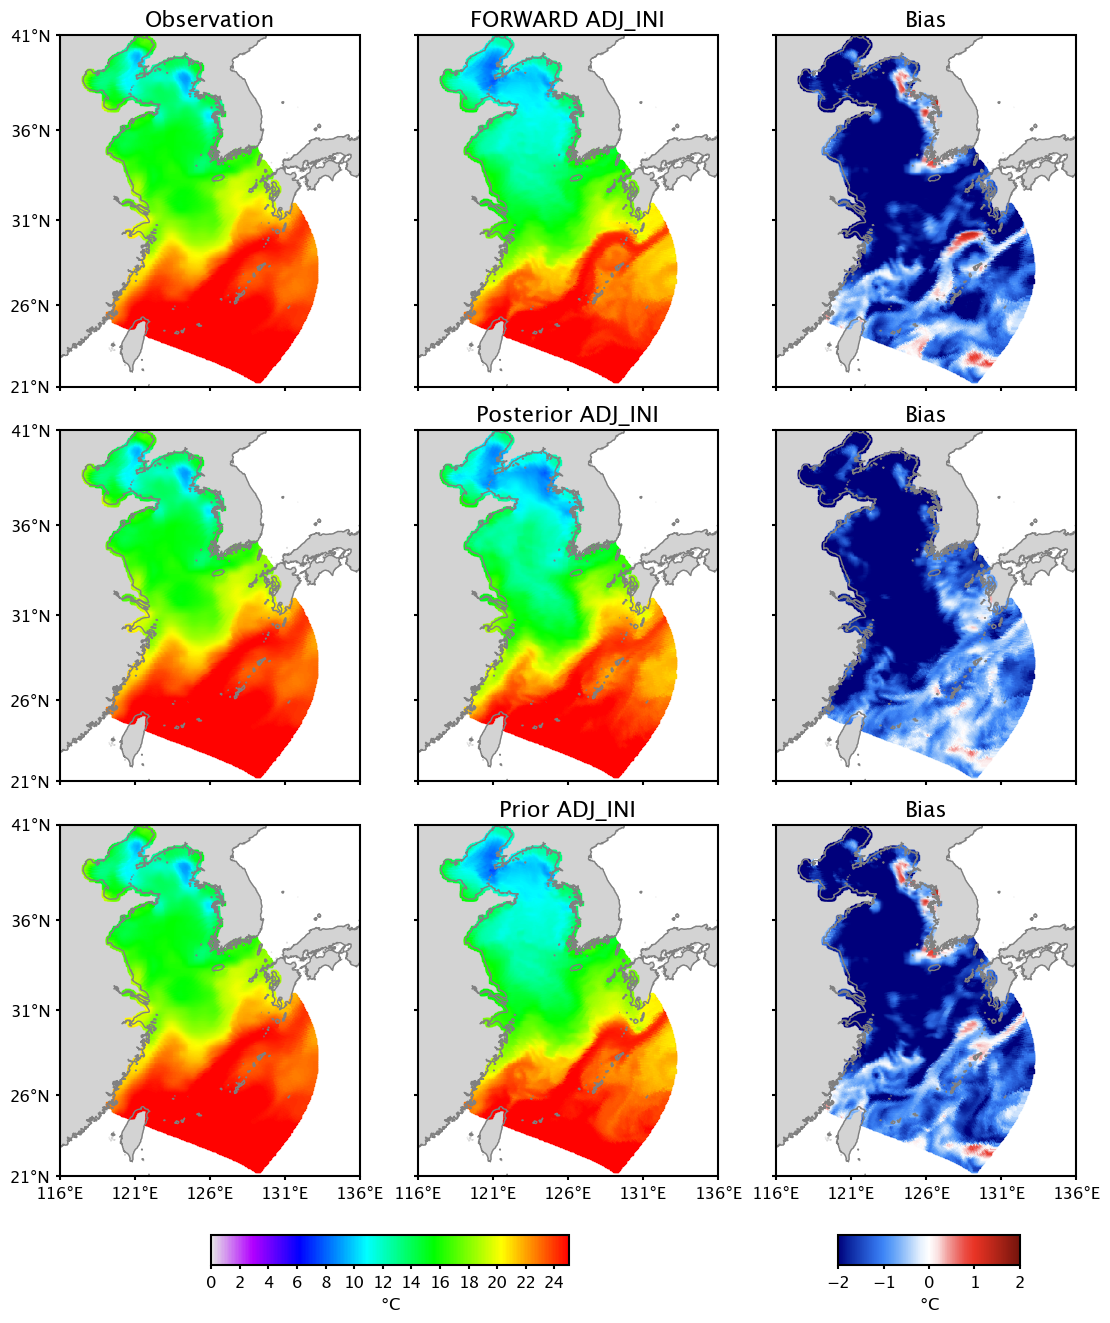

In [22]:
#==================================time-averaged area-specific 
#==================================posterior and prior spatial distribution 
#==================================validation 
area = 'all'
markersize = 10
draw_cb = True


if area == 'bh':
    figsize = (11,9)
    lon_bdy = [116.5,123.5];
    lat_bdy = [36,42];
    lon_interval = 3
    lat_interval = 3
    vmin_sst = 0
    vmax_sst = 8
elif area == 'ys':
    figsize = (11,9)
    lon_bdy = [122,128];
    lat_bdy = [34,38];
    lon_interval = 2
    lat_interval = 2
    vmin_sst = 6
    vmax_sst = 12
elif area == 'cre':
    figsize = (11,9)
    lon_bdy = [119.5,130.5];
    lat_bdy = [27,35];
    lon_interval = 3
    lat_interval = 3
    vmin_sst = 11
    vmax_sst = 18
elif area == 'ks':
    figsize = (11,9)
    lon_bdy = [120,133.5];

    lat_bdy = [20,31];
    lon_interval = 4
    lat_interval = 3
    vmin_sst = 22
    vmax_sst = 26
elif area =='all':
    figsize = (11,12)
    lon_bdy = [116,136];
    lat_bdy = [21,38.5];
    lon_interval = 5
    lat_interval = 5
    vmin_sst = 0
    vmax_sst = 25
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)



plt.rcParams['font.family'] = 'Lucida Grande'
iwda = 0
iwnl = 0
for it in range(1):
    fig = plt.figure(figsize=figsize, constrained_layout = True)
    #===============================observation spatial pattern
    ax = fig.add_subplot(3,3,4,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
    ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               timemean_obs[area],
               cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
               marker='s',
               transform = ccrs.PlateCarree())
    # ax.set_title('Observation',fontsize=16)
    # fig.text(0.12,0.49,str(obs_ds.survey_time.data[it])[:10]+'-12H',fontsize = 12)
    #===============================posterior spatial pattern
    ax = fig.add_subplot(3,3,5,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)
    
    c2=ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               timemean_daa[area][iwda],

               cmap = my_sst, vmin = vmin_sst,vmax=vmax_sst,
               marker='s',
               transform = ccrs.PlateCarree())
    ax.set_title('Posterior ADJ_INI',fontsize=16)
    
            #==== colobar
    # position=fig.add_axes([ 0.1875,0.12, 0.325, 0.045,])


    # cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(6,14,2))
    # for bnd in position.spines.keys():
    #         position.spines[bnd].set_linewidth('1.5')
    # position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

    # cb.set_label('$\degree$C',fontsize = 12) 
    #===============================innovation spatial pattern
    ax = fig.add_subplot(3,3,6,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    c3 = ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               timemean_ddaa[area][iwda],
               marker='s',
               vmin = -2, vmax = 2, cmap=my_div,
               transform = ccrs.PlateCarree())
    ax.set_title('Bias',fontsize=16)
        #---- colrbar
    # position=fig.add_axes([ 0.7575,0.12, 0.165, 0.045,])


    # cb2 = fig.colorbar(c3, cax = position, orientation='horizontal',ticks = np.arange(-2,3,1))
    # for bnd in position.spines.keys():
    #         position.spines[bnd].set_linewidth('1.5')
    # position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
    # cb2.set_label('$\degree$C',fontsize = 12) 
    # fig.colorbar(c3)
    # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

    # fig = plt.figure(figsize=figsize, constrained_layout = True)
    ax = fig.add_subplot(3,3,7,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    # ax.tick_params('x',labelbottom=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
    ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               timemean_obs[area],
               cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
               marker='s',
               transform = ccrs.PlateCarree())
    # ax.set_title('Observation',fontsize=16)
    # fig.text(0.12,0.49,str(obs_ds.survey_time.data[it])[:10]+'-12H',fontsize = 12)
    #===============================posterior spatial pattern
    ax = fig.add_subplot(3,3,8,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    # ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)
    
    c2=ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               timemean_dab[area][iwda],

               cmap = my_sst, vmin = vmin_sst,vmax=vmax_sst,
               marker='s',
               transform = ccrs.PlateCarree())
    ax.set_title('Prior ADJ_INI',fontsize=16)
    
            #==== colobar
    # position=fig.add_axes([ 0.1875,0.12, 0.325, 0.045,])


    # cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(6,14,2))
    # for bnd in position.spines.keys():
    #         position.spines[bnd].set_linewidth('1.5')
    # position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

    # cb.set_label('$\degree$C',fontsize = 12) 
    #===============================innovation spatial pattern
    ax = fig.add_subplot(3,3,9,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    # ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    c3 = ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               timemean_ddab[area][iwda],
               marker='s',
               vmin = -2, vmax = 2, cmap=my_div,
               transform = ccrs.PlateCarree())
    ax.set_title('Bias',fontsize=16)
        #---- colrbar
    # position=fig.add_axes([ 0.7575,0.12, 0.165, 0.045,])


    # cb2 = fig.colorbar(c3, cax = position, orientation='horizontal',ticks = np.arange(-2,3,1))
    # for bnd in position.spines.keys():
    #         position.spines[bnd].set_linewidth('1.5')
    # position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
    # cb2.set_label('$\degree$C',fontsize = 12) 
    # fig.colorbar(c3)
    # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

    # fig = plt.figure(figsize=figsize, constrained_layout = True)

    #===============================observation spatial pattern
    ax = fig.add_subplot(3,3,1,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)

    # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
    ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               timemean_obs[area],
               cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
               marker='s',
               transform = ccrs.PlateCarree())
    ax.set_title('Observation',fontsize=16)
    #===============================posterior spatial pattern
    ax = fig.add_subplot(3,3,2,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    c2=ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               timemean_nl[area][iwnl],

               cmap = my_sst, vmin = vmin_sst,vmax=vmax_sst,
               marker='s',
               transform = ccrs.PlateCarree())
    ax.set_title('FORWARD ADJ_INI',fontsize=16)
            #==== colobar
    if draw_cb:
        position=fig.add_axes([ 0.1875,-0.05, 0.325, 0.025,])


        cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+2,2))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

        cb.set_label('$\degree$C',fontsize = 12) 
    #===============================innovation spatial pattern
    ax = fig.add_subplot(3,3,3,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    c3 = ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               # np.nanmean( nl_Vars[area][iwnl].val_obsgrd[11:-24:24,area_index[area]].squeeze() - obs_inarea[area],axis = 0)-timemean_dnl[area],
               timemean_dnl[area],
               marker='s',
               vmin = -2, vmax = 2, cmap=my_div,
               transform = ccrs.PlateCarree())
    ax.set_title('Bias',fontsize=16)
        #---- colrbar
    if draw_cb:
        position=fig.add_axes([ 0.7575,-0.05, 0.165, 0.025,])


        cb2 = fig.colorbar(c3, cax = position, orientation='horizontal',ticks = np.arange(-2,3,1))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
        cb2.set_label('$\degree$C',fontsize = 12) 
        # fig.colorbar(c3)
    # plt.savefig('./fig_valid/exp_adj_ini/%s/romsi4dvar_valid2d_obsgrd_adj_ini_timemean.jpeg'%(area),dpi=1200,bbox_inches='tight')
    # plt.close()

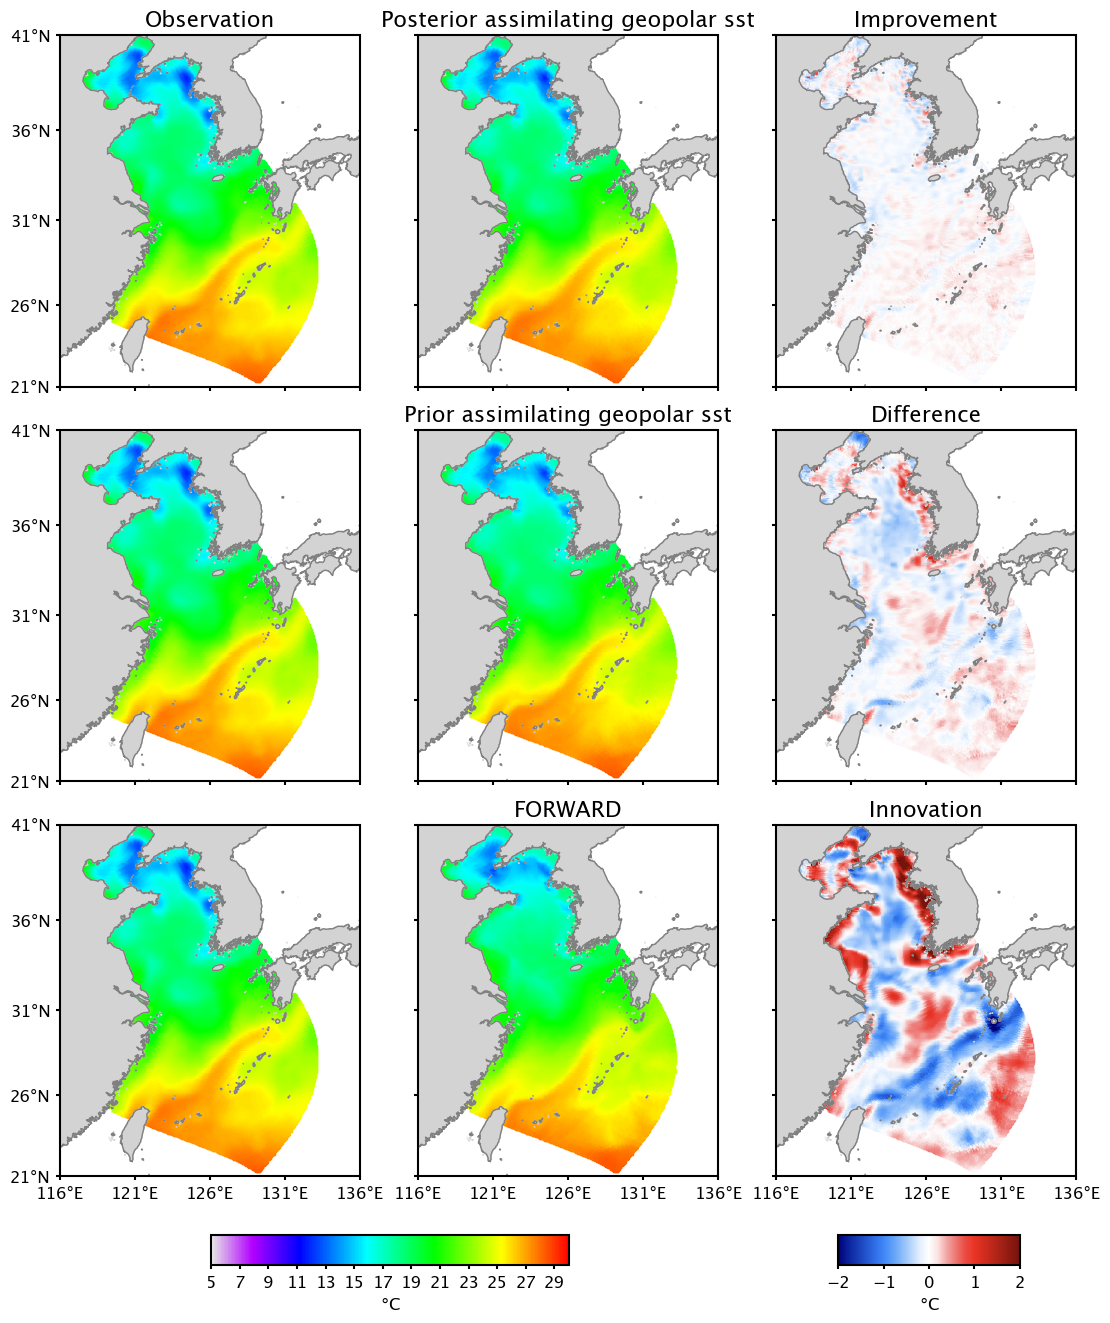

In [196]:
#==================================time-averaged area-specific 
#==================================posterior  distribution 
#==================================constrast between different configuration
area = 'all'
markersize = 10
draw_cb = True


if area == 'bh':
    figsize = (11,9)
    lon_bdy = [116.5,123.5];
    lat_bdy = [36,42];
    lon_interval = 3
    lat_interval = 3
    vmin_sst = 5
    vmax_sst = 30
elif area == 'ys':
    figsize = (11,9)
    lon_bdy = [122,128];
    lat_bdy = [34,38];
    lon_interval = 2
    lat_interval = 2
    vmin_sst = 6
    vmax_sst = 12
elif area == 'cre':
    figsize = (11,9)
    lon_bdy = [119.5,130.5];
    lat_bdy = [27,35];
    lon_interval = 3
    lat_interval = 3
    vmin_sst = 11
    vmax_sst = 18
elif area == 'ks':
    figsize = (11,9)
    lon_bdy = [120,133.5];

    lat_bdy = [20,31];
    lon_interval = 4
    lat_interval = 3
    vmin_sst = 22
    vmax_sst = 26
elif area =='all':
    figsize = (11,12)
    lon_bdy = [116,136];
    lat_bdy = [21,38.5];
    lon_interval = 5
    lat_interval = 5
    vmin_sst = 5
    vmax_sst = 30
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)



plt.rcParams['font.family'] = 'Lucida Grande'
iwda = 0
iwda1 = 0
iwnl = 0
for it in range(1):
    fig = plt.figure(figsize=figsize, constrained_layout = True)
    #===============================observation spatial pattern
    ax = fig.add_subplot(3,3,1,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
    ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               np.nanmean(obs_inarea[area],axis=0),
               cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
               marker='s',
               transform = ccrs.PlateCarree(),zorder=-2)
    ax.set_title('Observation',fontsize=16)
    # fig.text(0.12,0.49,str(obs_ds.survey_time.data[it])[:10]+'-12H',fontsize = 12)
    #===============================posterior spatial pattern
    ax = fig.add_subplot(3,3,2,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)
    
    c2=ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               
               np.nanmean(daa_Vars[area][iwda].val_obsgrd,axis=0),

               cmap = my_sst, vmin = vmin_sst,vmax=vmax_sst,
               marker='s',
               transform = ccrs.PlateCarree(),zorder=-2)
    ax.set_title('Posterior assimilating geopolar sst',fontsize=16)
    
            #==== colobar
    # position=fig.add_axes([ 0.1875,0.12, 0.325, 0.045,])


    # cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(6,14,2))
    # for bnd in position.spines.keys():
    #         position.spines[bnd].set_linewidth('1.5')
    # position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

    # cb.set_label('$\degree$C',fontsize = 12) 
    #===============================innovation spatial pattern
    ax = fig.add_subplot(3,3,3,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    c3 = ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               
                np.nanmean(np.array([ 
                           daa_Vars[area][iwda].val_obsgrd[iit*24,:]
                   -obs_inarea[area][iit,:] for iit in range(dat_len)]),axis=0),
               marker='s',
               vmin = -2, vmax = 2, cmap=my_div,
               transform = ccrs.PlateCarree(),zorder=-2)
    ax.set_title('Improvement',fontsize=16)
        #---- colrbar
    # position=fig.add_axes([ 0.7575,0.12, 0.165, 0.045,])


    # cb2 = fig.colorbar(c3, cax = position, orientation='horizontal',ticks = np.arange(-2,3,1))
    # for bnd in position.spines.keys():
    #         position.spines[bnd].set_linewidth('1.5')
    # position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
    # cb2.set_label('$\degree$C',fontsize = 12) 
    # fig.colorbar(c3)
    # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

    # fig = plt.figure(figsize=figsize, constrained_layout = True)
    ax = fig.add_subplot(3,3,4,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
    ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               np.nanmean(obs_inarea[area],axis=0),
               cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
               marker='s',
               transform = ccrs.PlateCarree(),zorder=-2)
    # ax.set_title('Observation',fontsize=16)
    # fig.text(0.12,0.49,str(obs_ds.survey_time.data[it])[:10]+'-12H',fontsize = 12)
    #===============================posterior spatial pattern
    ax = fig.add_subplot(3,3,5,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)
    
    c2=ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               np.nanmean(dab_Vars[area][iwda].val_obsgrd,axis=0),

               cmap = my_sst, vmin = vmin_sst,vmax=vmax_sst,
               marker='s',
               transform = ccrs.PlateCarree(),zorder=-2)
    ax.set_title('Prior assimilating geopolar sst',fontsize=16)
    
            #==== colobar
    # position=fig.add_axes([ 0.1875,0.12, 0.325, 0.045,])


    # cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(6,14,2))
    # for bnd in position.spines.keys():
    #         position.spines[bnd].set_linewidth('1.5')
    # position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

    # cb.set_label('$\degree$C',fontsize = 12) 
    #===============================innovation spatial pattern
    ax = fig.add_subplot(3,3,6,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    c3 = ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               
               np.nanmean(np.array([ 
                           dab_Vars[area][iwda].val_obsgrd[iit*24,:]
                   -obs_inarea[area][iit,:] for iit in range(dat_len)]),axis=0),
               marker='s',
               vmin = -2, vmax = 2, cmap=my_div,
               transform = ccrs.PlateCarree(),zorder=-2)
    ax.set_title('Difference',fontsize=16)
        #---- colrbar
    # position=fig.add_axes([ 0.7575,0.12, 0.165, 0.045,])


    # cb2 = fig.colorbar(c3, cax = position, orientation='horizontal',ticks = np.arange(-2,3,1))
    # for bnd in position.spines.keys():
    #         position.spines[bnd].set_linewidth('1.5')
    # position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
    # cb2.set_label('$\degree$C',fontsize = 12) 
    # fig.colorbar(c3)
    # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

    # fig = plt.figure(figsize=figsize, constrained_layout = True)

    #===============================observation spatial pattern
    ax = fig.add_subplot(3,3,7,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)

    # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
    ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               np.nanmean(obs_inarea[area],axis=0),
               cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
               marker='s',
               transform = ccrs.PlateCarree(),zorder=-2)
    # ax.set_title('Observation',fontsize=16)
    #===============================posterior spatial pattern
    ax = fig.add_subplot(3,3,8,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('y',labelleft=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    c2=ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               
               np.nanmean(nl_Vars[area][iwnl].val_obsgrd,axis=0),

               cmap = my_sst, vmin = vmin_sst,vmax=vmax_sst,
               marker='s',
               transform = ccrs.PlateCarree(),zorder=-2)
    ax.set_title('FORWARD',fontsize=16)
            #==== colobar
    if draw_cb:
        position=fig.add_axes([ 0.1875,-0.05, 0.325, 0.025,])


        cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+2,2))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

        cb.set_label('$\degree$C',fontsize = 12) 
    #===============================innovation spatial pattern
    ax = fig.add_subplot(3,3,9,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('y',labelleft=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    c3 = ax.scatter(obs_location[area_index[area],0],obs_location[area_index[area],1],
               markersize,
               # np.nanmean( nl_Vars[area][iwnl].val_obsgrd[11:-24:24,area_index[area]].squeeze() - obs_inarea[area],axis = 0)-timemean_dnl[area],
               np.nanmean(np.array([ 
                   0.5*(nl_Vars[area][iwnl].val_obsgrd[11+iit*24,:]
                               +nl_Vars[area][iwnl].val_obsgrd[12+iit*24,:])
                   -obs_inarea[area][iit,:] for iit in range(dat_len)]),axis=0),
                                                           
               # np.nanmean(nl_Vars[area][iwnl].val_obsgrd,axis=0)
               # -np.nanmean(obs_inarea[area],axis=0),
               marker='s',
               vmin = -2, vmax = 2, cmap=my_div,
               transform = ccrs.PlateCarree(),zorder=-2)
    ax.set_title('Innovation',fontsize=16)
        #---- colrbar
    if draw_cb:
        position=fig.add_axes([ 0.7575,-0.05, 0.165, 0.025,])


        cb2 = fig.colorbar(c3, cax = position, orientation='horizontal',ticks = np.arange(-2,3,1))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
        cb2.set_label('$\degree$C',fontsize = 12) 
        # fig.colorbar(c3)
    # plt.savefig('./fig_valid/%s/romsi4dvar_valid2d_obsgrd_adj_nud+ini_timemean.jpeg'%(area),dpi=1200,bbox_inches='tight')
    # plt.close()
# plt.savefig('./da_sst_sst_validation.jpeg',dpi=400,bbox_inches='tight')

In [193]:
 np.nanmean(np.array([ 
                   0.5*(nl_Vars[area][iwnl].val_obsgrd[11+iit*24,:]
                               +nl_Vars[area][iwnl].val_obsgrd[12+iit*24,:])
                   -obs_inarea[area][iit,:] for iit in range(dat_len)]),axis=0)

array([ 0.74291265,  0.65285722,  0.52028029, ..., -1.14269422,
       -1.2361565 , -1.20713828])

/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anacond

KeyboardInterrupt: 

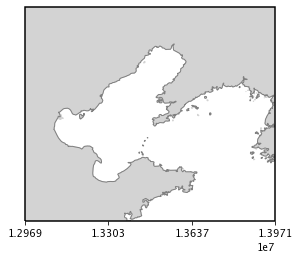

In [37]:
# time -variant difference between postrior and forward
lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)

markersize = 10
iwnl = 0
iwda = 1
plt.rcParams['font.family'] = 'Lucida Grande'
# area = 'ks'
# for area in ['bh','ys','cre','ks','all']:
for area in ['bh']:
    if area == 'bh':
        figsize = (11,4)
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 0
        vmax_sst = 8
        vmin_diff = -5
        vmax_diff = 5
        markersize = 15
        bc = 0.98
    elif area == 'ys':
        figsize = (11,4)
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vmin_sst = 6
        vmax_sst = 12
        vmin_diff = -3
        vmax_diff = 3
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        figsize = (11,4)
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 11
        vmax_sst = 18
        vmin_diff = -3
        vmax_diff = 3
        bc = 0.965
    elif area == 'ks':
        figsize = (11,4)
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        lon_interval = 4
        lat_interval = 3
        vmin_sst = 22
        vmax_sst = 26
        vmin_diff = -3
        vmax_diff = 3
        bc = 0.965
    elif area =='all':
        figsize = (11,5)
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];
        lon_interval = 5
        lat_interval = 5
        vmin_sst = 0
        vmax_sst = 25
        vmin_diff = -3
        vmax_diff = 3
        bc = 0.93
    for it in range(1,len(daa_Vars[area][iwda].ocean_time)):
    # for it in range(48,49):
        fig = plt.figure(figsize=figsize, constrained_layout = True)
        #===============================observation spatial pattern
        ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        # ax.tick_params('x',labelbottom=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
        ax.pcolormesh(nl_Vars[area][iwnl].lon,nl_Vars[area][iwnl].lat,
                       0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]),
                   cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Forward',fontsize=16)
        ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(daa_Vars[area][iwda].ocean_time.data[it])[:10]+'-%sH'%(str(daa_Vars[area][iwda].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
        #===============================posterior spatial pattern
        ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)

        c2=ax.pcolormesh(daa_Vars[area][iwnl].lon,daa_Vars[area][iwnl].lat,
                       daa_Vars[area][iwnl].value[it,:,:],
                   cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Posterior',fontsize=16)

                #==== colobar
        
        position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
        cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+2,2))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

        cb.set_label('$\degree$C',fontsize = 12) 
        #===============================innovation spatial pattern
        ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        cb3 = ax.pcolormesh(daa_Vars[area][iwnl].lon,daa_Vars[area][iwnl].lat,
                       daa_Vars[area][iwnl].value[it,:,:]-
                           0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]),
                   cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Difference',fontsize=16)
            #---- colrbar
        
        position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


        cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
        for bnd in position.spines.keys(): 
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
        cb2.set_label('$\degree$C',fontsize = 12) 
        # fig.colorbar(c3)
        # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

        # fig = plt.figure(figsize=figsize, constrained_layout = True)

        #===============================observation spatial pattern
        
        plt.savefig('./fig_evolution/exp_adj_ini_nud_3d_b12hr/post/sst/%s/%s.jpeg'%(area,str(it)),dpi=300,bbox_inches='tight')
        plt.close()

In [54]:
it

0

/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_98749/3133164200.py:121: RuntimeWarning: Mean of empty slice
  np.nanmean( nl_Vars[area][iwnl].value,
/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_98749/3133164200.py:150: RuntimeWarning: Mean of empty slice
  np.nanmean(daa_Vars[area][iwda].value,axis=0),
/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_98749/3133164200.py:187: RuntimeWarning: Mean of empty slice
  np.nanmean(
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


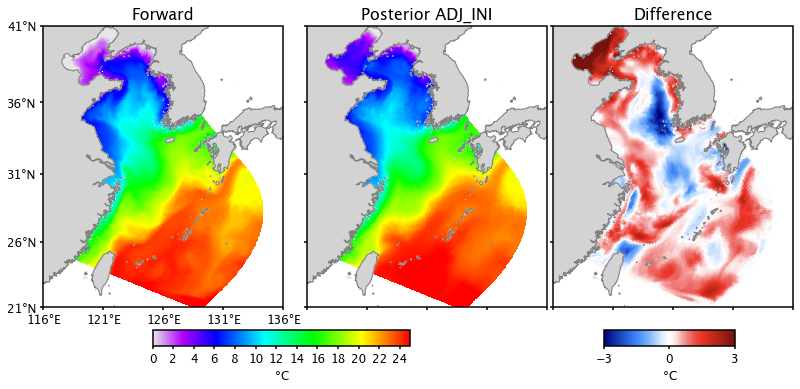

In [39]:
# time mean of difference between posterior and forward
lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)


d_interval = 2
iwnl = 0
iwda = 0
plt.rcParams['font.family'] = 'Lucida Grande'
# area = 'ks'
for area in ['all']:
# for area in ['all']:
    if area == 'bh':
        figsize = (11,4)
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 0
        vmax_sst = 8
        vmin_diff = -5
        vmax_diff = 5
        markersize = 15
        bc = 0.98
    elif area == 'ys':
        figsize = (11,4)
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vmin_sst = 6
        vmax_sst = 12
        vmin_diff = -3
        vmax_diff = 3
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        figsize = (11,4)
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 11
        vmax_sst = 18
        vmin_diff = -3
        vmax_diff = 3
        bc = 0.965
    elif area == 'ks':
        figsize = (11,4)
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        lon_interval = 4
        lat_interval = 3
        vmin_sst = 22
        vmax_sst = 26
        vmin_diff = -3
        vmax_diff = 3
        bc = 0.965
    elif area =='all':
        figsize = (11,5)
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];
        lon_interval = 5
        lat_interval = 5
        vmin_sst = 0
        vmax_sst = 25
        vmin_diff = -3
        vmax_diff = 3
        bc = 0.93
    fig = plt.figure(figsize=figsize, constrained_layout = True)
    #===============================observation spatial pattern
    ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    # ax.tick_params('x',labelbottom=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
    ax.pcolormesh(nl_Vars[area][iwnl].lon,nl_Vars[area][iwnl].lat,
                  np.nanmean( nl_Vars[area][iwnl].value,
                             axis = 0),
                  # cmap = my_sst, norm = norm,
                  cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,

               transform = ccrs.PlateCarree(),zorder = -1)
    ax.set_title('Forward',fontsize=16)
    # ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(daa_Vars[area][iwda].ocean_time.data[it])[:10]+'-%sH'%(str(daa_Vars[area][iwda].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
    #===============================posterior spatial pattern
    ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)

    c2=ax.pcolormesh(daa_Vars[area][iwda].lon,daa_Vars[area][iwda].lat,
                   np.nanmean(daa_Vars[area][iwda].value,axis=0),
               # cmap = my_sst, norm = norm,
               cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,

               transform = ccrs.PlateCarree(),zorder = -1)
    ax.set_title('Posterior ADJ_INI',fontsize=16)

            #==== colobar

    position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
    cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+d_interval,d_interval))
    for bnd in position.spines.keys():
            position.spines[bnd].set_linewidth('1.5')
    position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

    cb.set_label('$\degree$C',fontsize = 12) 
    #===============================innovation spatial pattern
    ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    cb3 = ax.pcolormesh(daa_Vars[area][iwda].lon,daa_Vars[area][iwda].lat,
                  np.nanmean(
                      daa_Vars[area][iwda].value[1:,:,:]-
                       np.array(
                                [0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]) for it in range(1,len(daa_Vars[area][iwda].ocean_time))]
                            ), axis = 0),
               cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,

               transform = ccrs.PlateCarree(),zorder = -1)
    ax.set_title('Difference',fontsize=16)
        #---- colrbar

    position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


    cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
    for bnd in position.spines.keys():
            position.spines[bnd].set_linewidth('1.5')
    position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
    cb2.set_label('$\degree$C',fontsize = 12) 
    # fig.colorbar(c3)
    # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

    # fig = plt.figure(figsize=figsize, constrained_layout = True)

    #===============================observation spatial pattern

    plt.savefig('./fig_evolution/exp_adj_ini/post/sst/%s_roms_i4dvar_contrast_adj_ini_forw.vs.post_timemean2.jpeg'%(area),dpi=1200,bbox_inches='tight')
    # plt.close()

/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_14133/3703973749.py:122: RuntimeWarning: Mean of empty slice
  np.nanmean(daa_Vars[area][iwda].value,axis=0),
/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_14133/3703973749.py:150: RuntimeWarning: Mean of empty slice
  np.nanmean(daa_Vars[area][iwda1].value,axis=0),
/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_14133/3703973749.py:187: RuntimeWarning: Mean of empty slice
  np.nanmean(
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_14133/3703973749.py:122: RuntimeWarning: Mean of empty slice
  np.nanmean(daa_Vars[area][iwda].value,axis=0),
/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_14133/3703973749.py:150: RuntimeWarning: Mean of empty sl

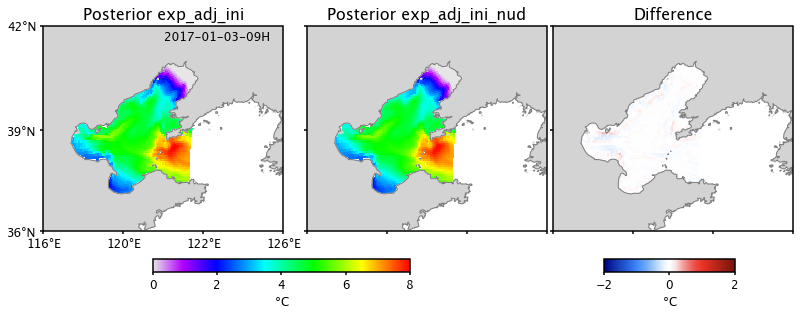

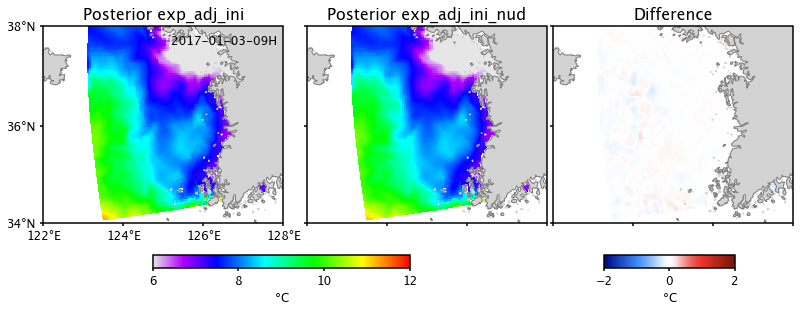

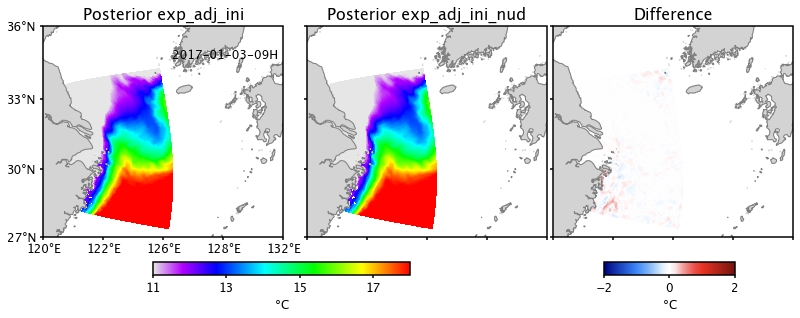

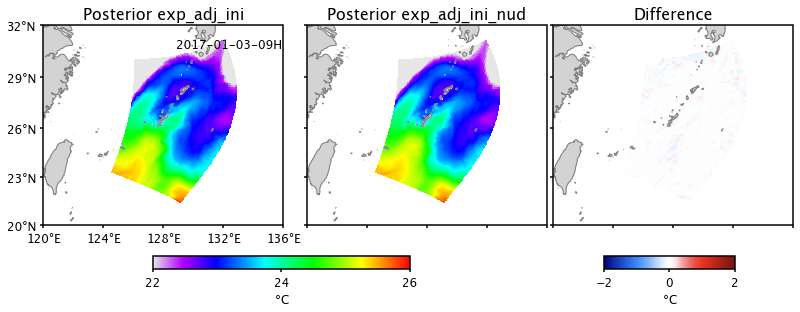

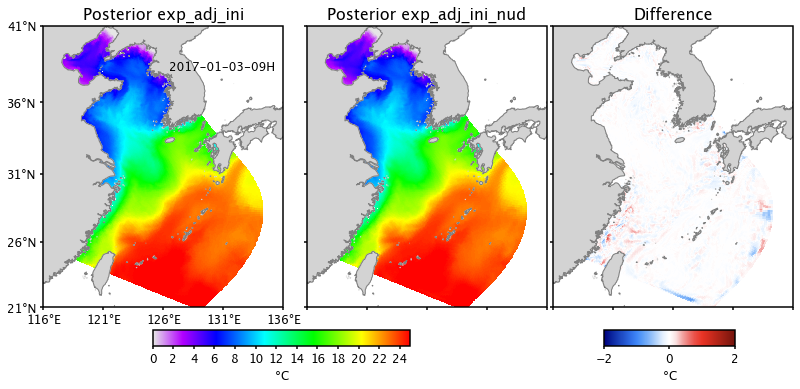

In [56]:
# time mean of difference between posterior and forward
lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)


d_interval = 2
iwnl = 0
iwda = 0
iwda1 =2
plt.rcParams['font.family'] = 'Lucida Grande'
# area = 'ks'
for area in ['bh','ys','cre','ks','all']:
# for area in ['all']:
    if area == 'bh':
        figsize = (11,4)
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 0
        vmax_sst = 8
        vmin_diff = -2
        vmax_diff = 2
        markersize = 15
        bc = 0.98
    elif area == 'ys':
        figsize = (11,4)
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vmin_sst = 6
        vmax_sst = 12
        vmin_diff = -2
        vmax_diff = 2
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        figsize = (11,4)
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 11
        vmax_sst = 18
        vmin_diff = -2
        vmax_diff = 2
        bc = 0.965
    elif area == 'ks':
        figsize = (11,4)
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        lon_interval = 4
        lat_interval = 3
        vmin_sst = 22
        vmax_sst = 26
        vmin_diff = -2
        vmax_diff = 2
        bc = 0.965
    elif area =='all':
        figsize = (11,5)
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];
        lon_interval = 5
        lat_interval = 5
        vmin_sst = 0
        vmax_sst = 25
        vmin_diff = -2
        vmax_diff = 2
        bc = 0.93
    fig = plt.figure(figsize=figsize, constrained_layout = True)
    #===============================observation spatial pattern
    ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    # ax.tick_params('x',labelbottom=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
    ax.pcolormesh(daa_Vars[area][iwda].lon,daa_Vars[area][iwda].lat,
                   np.nanmean(daa_Vars[area][iwda].value,axis=0),
               # cmap = my_sst, norm = norm,
               cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,

               transform = ccrs.PlateCarree(),zorder = -1)
    ax.set_title('Posterior exp_adj_ini',fontsize=16)
    ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(daa_Vars[area][iwda].ocean_time.data[it])[:10]+'-%sH'%(str(daa_Vars[area][iwda].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
    #===============================posterior spatial pattern
    ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)

    c2=ax.pcolormesh(daa_Vars[area][iwda1].lon,daa_Vars[area][iwda1].lat,
                   np.nanmean(daa_Vars[area][iwda1].value,axis=0),
               # cmap = my_sst, norm = norm,
               cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,

               transform = ccrs.PlateCarree(),zorder = -1)
    ax.set_title('Posterior exp_adj_ini_nud',fontsize=16)

            #==== colobar

    position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
    cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+d_interval,d_interval))
    for bnd in position.spines.keys():
            position.spines[bnd].set_linewidth('1.5')
    position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

    cb.set_label('$\degree$C',fontsize = 12) 
    #===============================innovation spatial pattern
    ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    cb3 = ax.pcolormesh(daa_Vars[area][iwda].lon,daa_Vars[area][iwda].lat,
                  np.nanmean(
                      daa_Vars[area][iwda1].value[1:,:,:]-
                      daa_Vars[area][iwda].value[1:,:,:]
                            , axis = 0),
               cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,

               transform = ccrs.PlateCarree(),zorder = -1)
    ax.set_title('Difference',fontsize=16)
        #---- colrbar

    position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


    cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
    for bnd in position.spines.keys():
            position.spines[bnd].set_linewidth('1.5')
    position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
    cb2.set_label('$\degree$C',fontsize = 12) 
    # fig.colorbar(c3)
    # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

    # fig = plt.figure(figsize=figsize, constrained_layout = True)

    #===============================observation spatial pattern

    plt.savefig('./fig_contrast/adj_ini.vs.adj_ini_nud/post/sst/%s_roms_i4dvar_contrast_adj_ini.vs.nud_ini_timemean.jpeg'%(area),dpi=1200,bbox_inches='tight')
    # plt.close()

In [34]:
# time -variant difference between postrior and forward
lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)

markersize = 10
iwnl = 0
iwda = 1
plt.rcParams['font.family'] = 'Lucida Grande'
# area = 'ks'
for area in ['bh','ys','cre','ks','all']:
# for area in ['all']:
    if area == 'bh':
        figsize = (11,4)
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 0
        vmax_sst = 8
        vmin_diff = -5
        vmax_diff = 5
        markersize = 15
        bc = 0.98
    elif area == 'ys':
        figsize = (11,4)
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vmin_sst = 6
        vmax_sst = 12
        vmin_diff = -3
        vmax_diff = 3
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        figsize = (11,4)
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 11
        vmax_sst = 18
        vmin_diff = -3
        vmax_diff = 3
        bc = 0.965
    elif area == 'ks':
        figsize = (11,4)
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        lon_interval = 4
        lat_interval = 3
        vmin_sst = 22
        vmax_sst = 26
        vmin_diff = -3
        vmax_diff = 3
        bc = 0.965
    elif area =='all':
        figsize = (11,5)
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];
        lon_interval = 5
        lat_interval = 5
        vmin_sst = 0
        vmax_sst = 25
        vmin_diff = -3
        vmax_diff = 3
        bc = 0.93
    for it in range(1,len(daa_Vars[area][iwda].ocean_time)):
    # for it in range(1,2):
        fig = plt.figure(figsize=figsize, constrained_layout = True)
        #===============================observation spatial pattern
        ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        # ax.tick_params('x',labelbottom=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
        ax.pcolormesh(nl_Vars[area][iwnl].lon,nl_Vars[area][iwnl].lat,
                       0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]),
                   cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Forward',fontsize=16)
        ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(daa_Vars[area][iwda].ocean_time.data[it])[:10]+'-%sH'%(str(daa_Vars[area][iwda].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
        #===============================posterior spatial pattern
        ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)

        c2=ax.pcolormesh(daa_Vars[area][iwnl].lon,daa_Vars[area][iwnl].lat,
                       daa_Vars[area][iwnl].value[it,:,:],
                   cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Posterior',fontsize=16)

                #==== colobar
        
        position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
        cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+2,2))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

        cb.set_label('$\degree$C',fontsize = 12) 
        #===============================innovation spatial pattern
        ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        cb3 = ax.pcolormesh(daa_Vars[area][iwnl].lon,daa_Vars[area][iwnl].lat,
                       daa_Vars[area][iwnl].value[it,:,:]-
                           0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]),
                   cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Difference',fontsize=16)
            #---- colrbar
        
        position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


        cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
        for bnd in position.spines.keys(): 
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
        cb2.set_label('$\degree$C',fontsize = 12) 
        # fig.colorbar(c3)
        # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

        # fig = plt.figure(figsize=figsize, constrained_layout = True)

        #===============================observation spatial pattern
        
        plt.savefig('./fig_evolution/exp_adj_ini_nud/post/sst/%s/%s.jpeg'%(area,str(it)),dpi=300,bbox_inches='tight')
        plt.close()

/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anacond

/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anacond

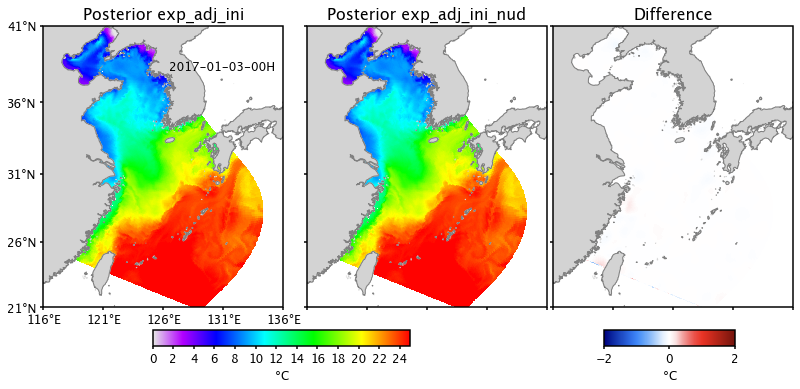

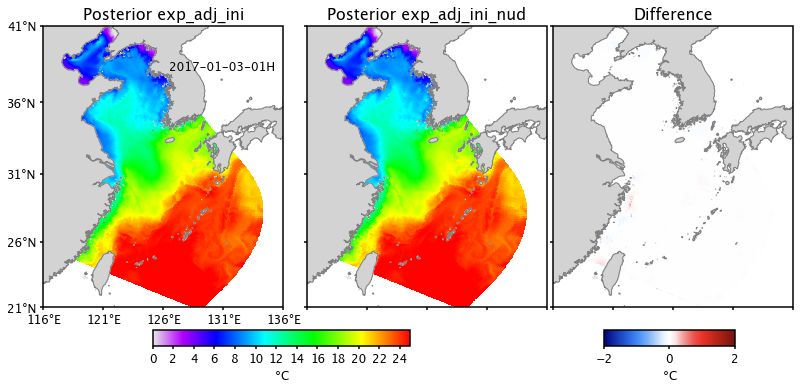

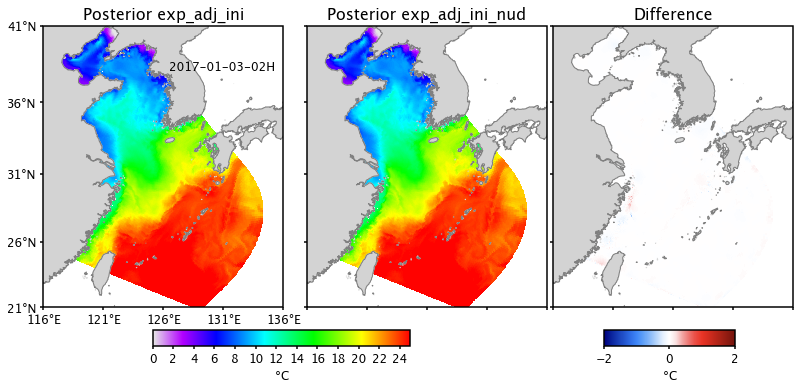

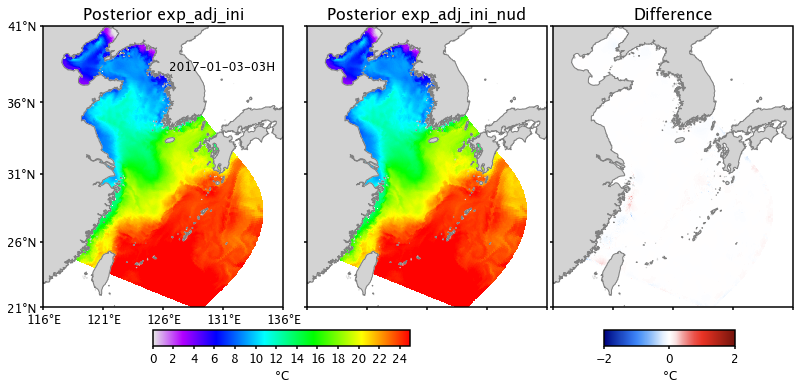

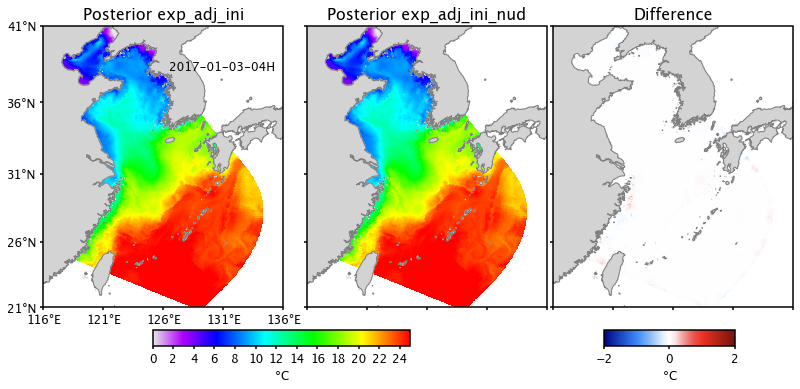

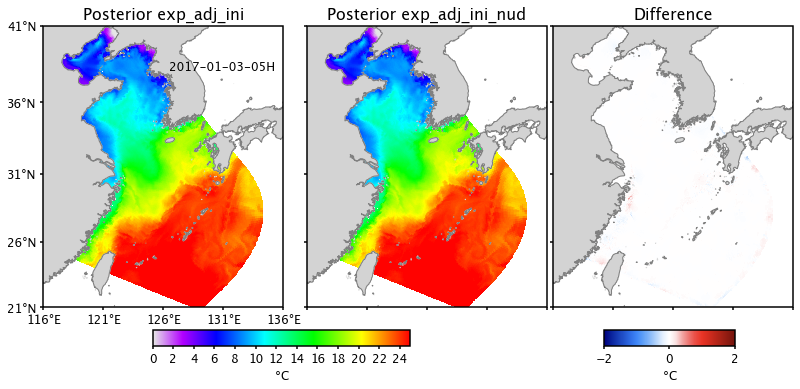

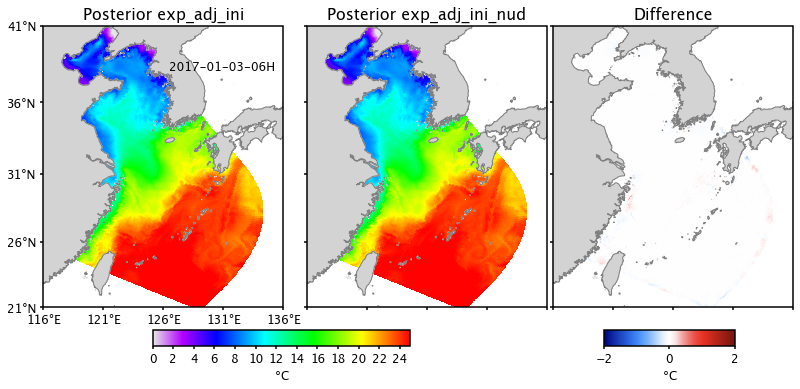

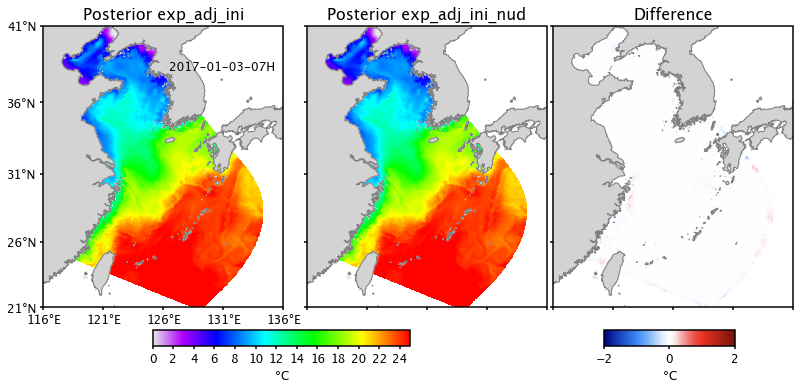

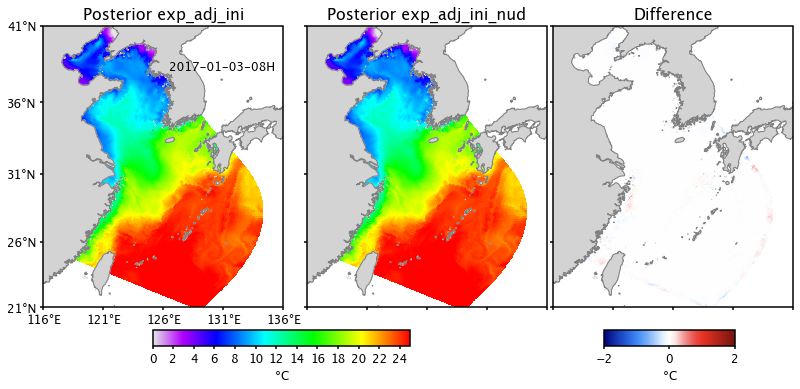

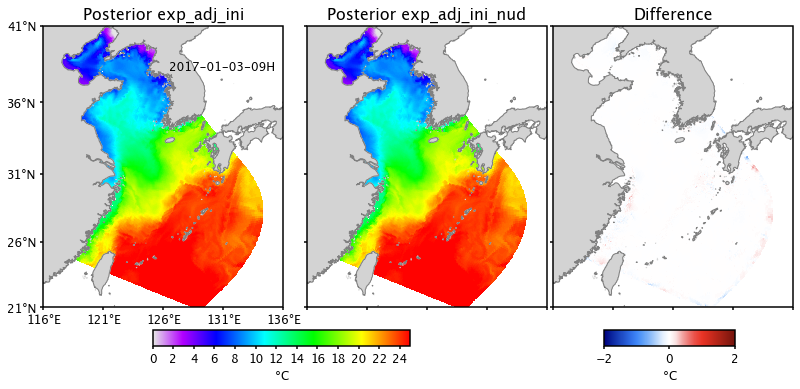

In [54]:
# ys 
# lon_bdy = [122,128];
# lat_bdy = [34,38];
# vmin_sst = 6
# vmax_sst = 12
# cre
# lon_bdy = [119.5,128.5];
# lat_bdy = [27,35];
# vmin_sst = 11
# vmax_sst = 18
# bh 
# lon_bdy = [116.5,123.5];
# lat_bdy = [36,42];
# vmin_sst = 0
# vmax_sst = 8
# ks 
lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)

markersize = 10
iwnl = 0
iwda = 0
iwda1 =2
plt.rcParams['font.family'] = 'Lucida Grande'
# area = 'ks'
# for area in ['bh','ys','cre','ks','all']:
for area in ['all']:
    if area == 'bh':
        figsize = (11,4)
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 0
        vmax_sst = 8
        vmin_diff = -2
        vmax_diff = 2
        markersize = 15
        bc = 0.98
    elif area == 'ys':
        figsize = (11,4)
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vmin_sst = 6
        vmax_sst = 12
        vmin_diff = -2
        vmax_diff = 2
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        figsize = (11,4)
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vmin_sst = 11
        vmax_sst = 18
        vmin_diff = -2
        vmax_diff = 2
        bc = 0.965
    elif area == 'ks':
        figsize = (11,4)
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        lon_interval = 4
        lat_interval = 3
        vmin_sst = 22
        vmax_sst = 26
        vmin_diff = -2
        vmax_diff = 2
        bc = 0.965
    elif area =='all':
        figsize = (11,5)
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];
        lon_interval = 5
        lat_interval = 5
        vmin_sst = 0
        vmax_sst = 25
        vmin_diff = -2
        vmax_diff = 2
        bc = 0.93
    # for it in range(0,len(daa_Vars[area][iwda].ocean_time)):
    for it in range(0,10):
        fig = plt.figure(figsize=figsize, constrained_layout = True)
        #===============================observation spatial pattern
        ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        # ax.tick_params('x',labelbottom=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
        ax.pcolormesh(daa_Vars[area][iwnl].lon,daa_Vars[area][iwnl].lat,
                       daa_Vars[area][iwda].value[it,:,:],
                   cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Posterior exp_adj_ini',fontsize=16)
        ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(daa_Vars[area][iwda].ocean_time.data[it])[:10]+'-%sH'%(str(daa_Vars[area][iwda].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
        #===============================posterior spatial pattern
        ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)

        c2=ax.pcolormesh(daa_Vars[area][iwnl].lon,daa_Vars[area][iwnl].lat,
                       daa_Vars[area][iwda1].value[it,:,:],
                   cmap = my_sst,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Posterior exp_adj_ini_nud',fontsize=16)

                #==== colobar
        
        position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
        cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+2,2))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

        cb.set_label('$\degree$C',fontsize = 12) 
        #===============================innovation spatial pattern
        ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        cb3 = ax.pcolormesh(daa_Vars[area][iwnl].lon,daa_Vars[area][iwnl].lat,
                       daa_Vars[area][iwda1].value[it,:,:]-
                           daa_Vars[area][iwda].value[it,:,:],
                   cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Difference',fontsize=16)
            #---- colrbar
        
        position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


        cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
        for bnd in position.spines.keys(): 
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
        cb2.set_label('$\degree$C',fontsize = 12) 
        # fig.colorbar(c3)
        # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

        # fig = plt.figure(figsize=figsize, constrained_layout = True)

        #===============================observation spatial pattern
        
        plt.savefig('./fig_contrast/adj_ini.vs.adj_ini_nud/post/sst/%s/%s_1.jpeg'%(area,str(it)),dpi=300,bbox_inches='tight')
        # plt.close()